# This code finds the normalized (z-scored) log amplitude of a recording, then sets a threshold to detect if  there is song in the recording

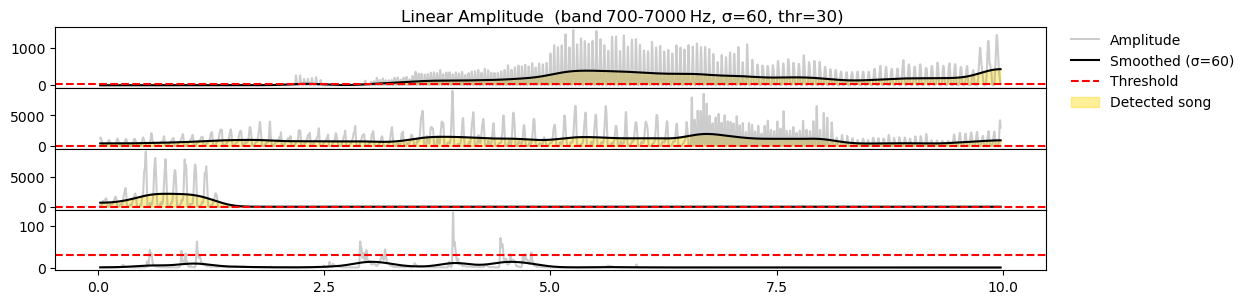

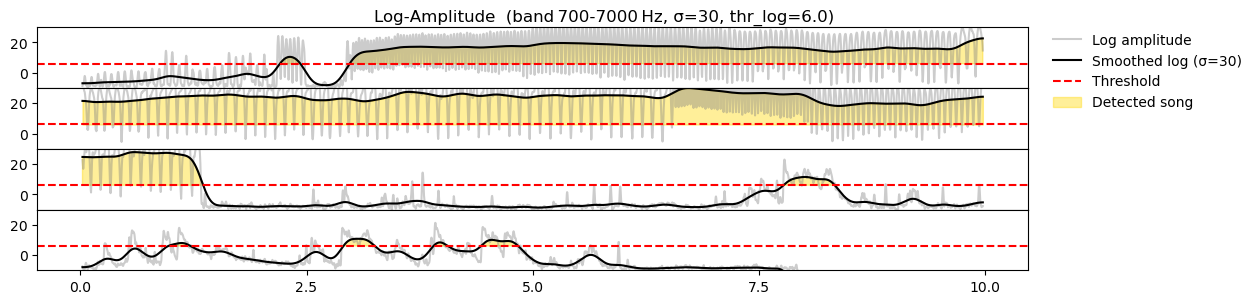

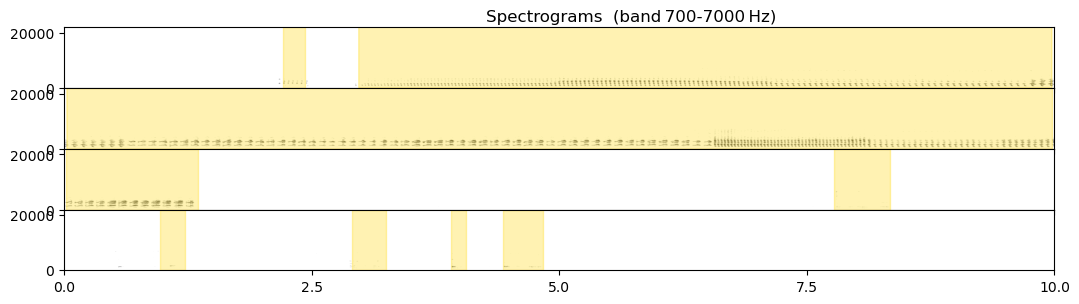


Detected song intervals (s):
      2.21 –     2.43
      2.98 –     9.97
     10.02 –    19.97
     20.02 –    21.36
     27.77 –    28.34
     30.97 –    31.22
     32.91 –    33.25
     33.90 –    34.06
     34.43 –    34.84


In [7]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: Optional[float] = None,
        threshold_log: Optional[float] = None,
        log_base: float = 10
    ) -> List[Tuple[float, float]]:

    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps

    # ---------- Load & band‑pass filter ----------
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ---------- Segment bookkeeping ----------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ---------- Figure stacks (no vertical spacing) ----------
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ---------- Per‑segment processing ----------
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear & log amplitude
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        amp_log = 10 * np.log10(amp + eps) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90) #was 90 - try out 80
        mask_log = amp_log_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ---- Linear amplitude plot ----
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4,
                 label='Amplitude' if i == 0 else None)
        axL.plot(t, amp_s, color='black',
                 label=f'Smoothed (σ={sigma})' if i == 0 else None)
        axL.axhline(threshold, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axL.fill_between(t, amp_s, threshold, where=mask_lin,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Log amplitude plot ----
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4,
                  label='Log amplitude' if i == 0 else None)
        axLg.plot(t, amp_log_s, color='black',
                  label=f'Smoothed log (σ={sigma_log})' if i == 0 else None)
        axLg.axhline(threshold_log, color='red', ls='--',
                     label='Threshold' if i == 0 else None)
        axLg.fill_between(t, amp_log_s, threshold_log, where=mask_log,
                          color='gold', alpha=0.4,
                          label='Detected song' if i == 0 else None)
        axLg.set_ylim(-10, 30)
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Spectrogram plot ----
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- Titles & final layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude  (band {bp}, σ={sigma_log}, thr_log={threshold_log:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)  # room for legends

    plt.show()

    # ---------- Console output ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=60,
            threshold=30,
            sigma_log=30,
            threshold_log=6     # dB
        )
    else:
        print("Example WAV not found:", wav_path)


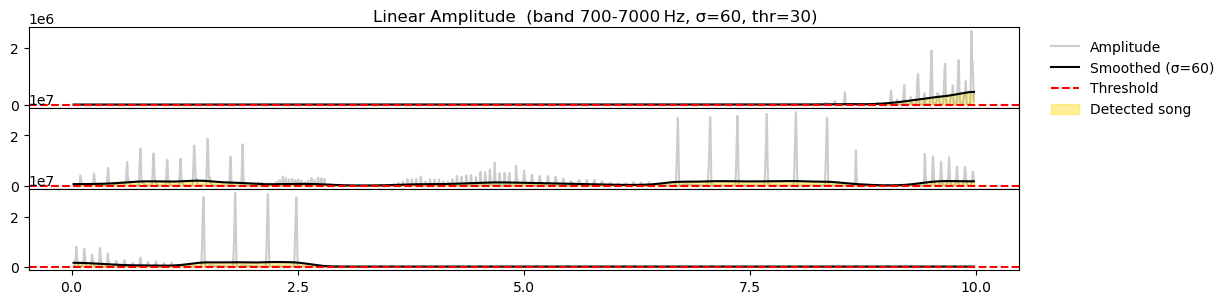

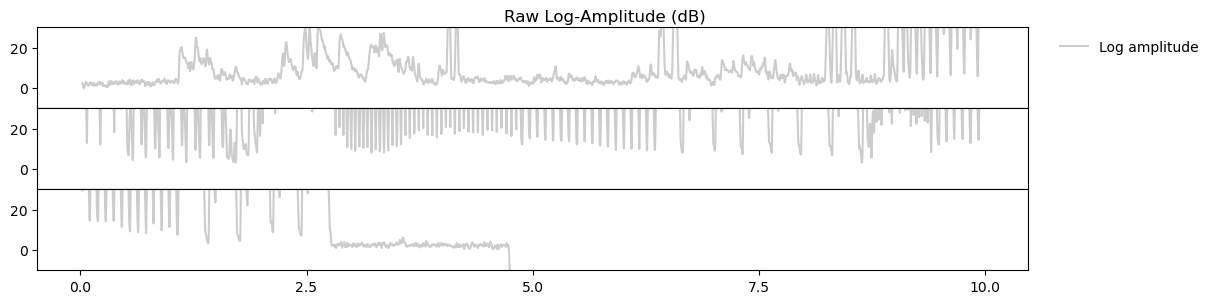

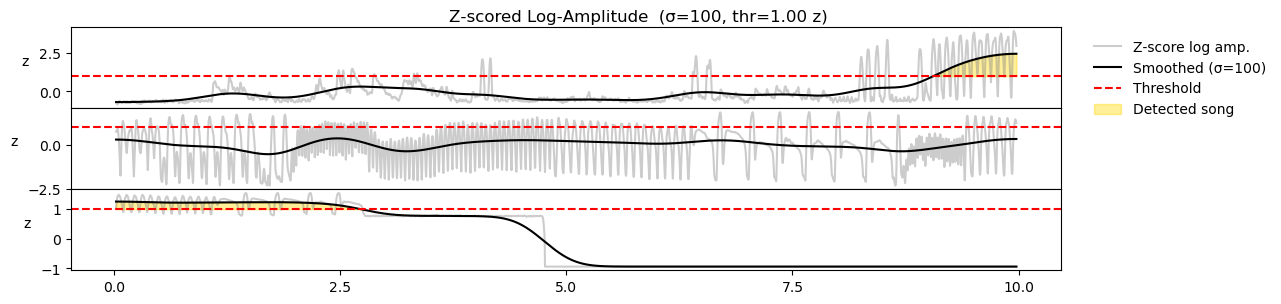

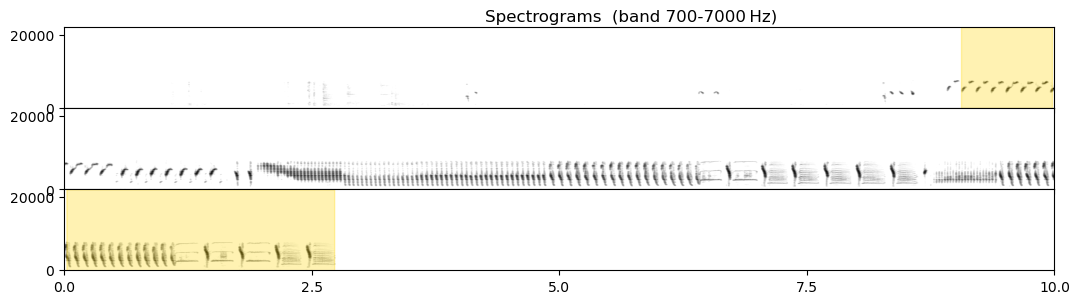


Detected song intervals (s):
      9.06 –     9.97
     20.02 –    22.73


In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ───────────────────────── screen‑size helper ────────────────────────────────
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100        # ≈ inches (100 dpi assumption)

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps               # tiny constant to avoid log(0)

# ─────────────────────── mask → [start, end] helper ──────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ─────────────────────────────── main routine ───────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma: float = 100,
    threshold: float = 0.05,
    sigma_log: Optional[float] = None,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:

    if sigma_log is None:
        sigma_log = sigma

    # ── Load & band‑pass filter ──────────────────────────────────────────────
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ── Segment bookkeeping ─────────────────────────────────────────────────
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ── Create 4 stacked figure groups (no vertical spacing) ────────────────
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    # 🔸 MOD – new figure for z‑scored log envelope
    fig3, axs_zsc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig4, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_zsc, axs_spc = \
            [axs_lin], [axs_log], [axs_zsc], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ── Per‑segment processing ──────────────────────────────────────────────
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # ── Spectrogram ─────────────────────────────────────────────────────
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # ── Linear amplitude envelope ──────────────────────────────────────
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        # ── Log envelope (raw dB) ──────────────────────────────────────────
        amp_log = (10 * np.log10(amp + eps) if log_base == 10
                   else np.log(amp + eps))

        # 🔸 MOD – z‑score BEFORE smoothing
        mean_log = amp_log.mean()
        std_log  = amp_log.std() + eps
        amp_log_z = (amp_log - mean_log) / std_log
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)

        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ── Plot ① Linear amplitude ────────────────────────────────────────
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4,
                 label='Amplitude' if i == 0 else None)
        axL.plot(t, amp_s, color='black',
                 label=f'Smoothed (σ={sigma})' if i == 0 else None)
        axL.axhline(threshold, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axL.fill_between(t, amp_s, threshold, where=mask_lin,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ② Log envelope (raw dB) ───────────────────────────────────
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4,
                  label='Log amplitude' if i == 0 else None)
        axLg.set_ylim(-10, 30)
        axLg.set_xticks([] if i < n_seg - 1 else
                        np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 🔸 Plot ③ Z‑scored log envelope ──────────────────────────────────
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i == 0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i == 0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ④ Spectrogram ────────────────────────────────────────────
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))

    # ── Titles & layout ────────────────────────────────────────────────────
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})',
                  fontsize=12)
    fig2.suptitle('Raw Log‑Amplitude (dB)', fontsize=12)
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, '
                  f'thr={threshold_log:.2f} z)', fontsize=12)
    fig4.suptitle(f'Spectrograms  (band {bp})', fontsize=12)

    for fig in (fig1, fig2, fig3, fig4):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    # ── Console output ────────────────────────────────────────────────────
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=60,
            threshold=30,
            sigma_log=100,
            threshold_log=.0   #  z‑score units
        )
    else:
        print("Example WAV not found:", wav_path)


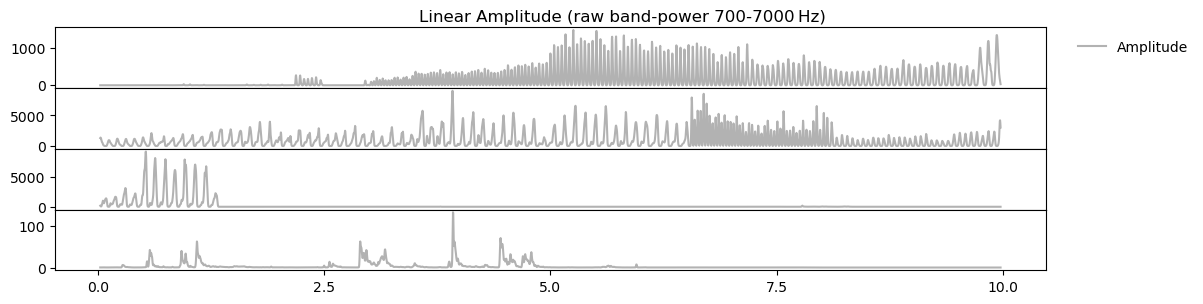

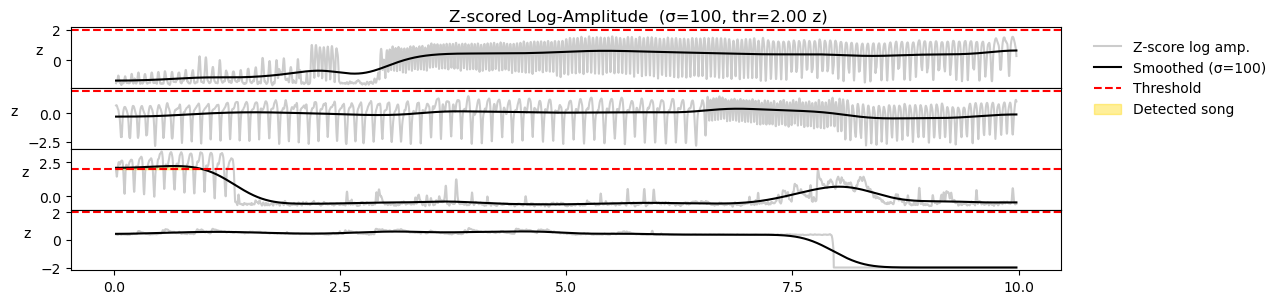

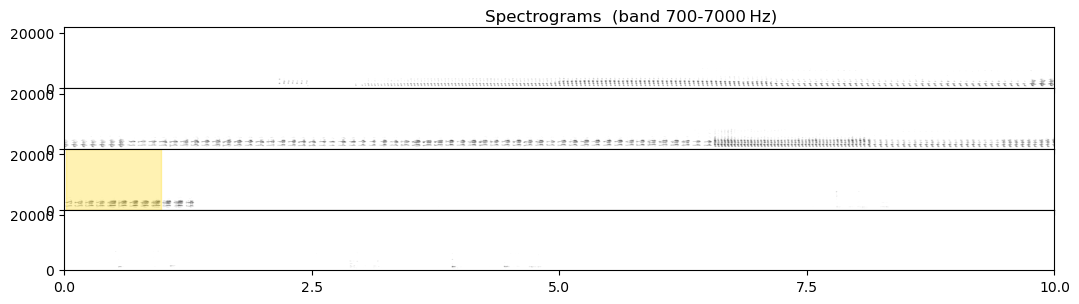


Detected song intervals (s):
     20.02 –    20.98


In [3]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ───────────────────────── screen‑size helper ────────────────────────────────
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100        # ≈ inches (100 dpi assumption)

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps               # tiny constant to avoid log(0)

# ─────────────────────── mask → [start, end] helper ──────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    """Convert a Boolean mask (True = “song”) to absolute time intervals."""
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ─────────────────────────────── main routine ───────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:
    """
    Visualise a WAV file in stacked panels and detect song using the
    z‑scored *log* amplitude envelope.  Linear amplitude is now plotted
    raw‑only (no smoothing / threshold).
    """

    # ── Load & band‑pass filter ─────────────────────────────────────────────
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ── Segment bookkeeping ─────────────────────────────────────────────────
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ── Create 3 stacked figure groups (no vertical spacing) ────────────────
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_zsc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_zsc, axs_spc = [axs_lin], [axs_zsc], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ── Per‑segment processing ──────────────────────────────────────────────
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # ── Spectrogram ─────────────────────────────────────────────────────
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # ── Band‑power amplitude (linear + log) ────────────────────────────
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)                    # linear
        amp_log = (10 * np.log10(amp + eps) if log_base == 10   # log‑dB
                   else np.log(amp + eps))

        # ── Z‑score log envelope, then smooth & threshold ──────────────────
        amp_log_z = (amp_log - amp_log.mean()) / (amp_log.std() + eps)
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)

        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ── Plot ① Linear amplitude (raw only) ─────────────────────────────
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ② Z‑scored log envelope ───────────────────────────────────
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i == 0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i == 0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ③ Spectrogram ─────────────────────────────────────────────
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))

    # ── Titles & layout ────────────────────────────────────────────────────
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude (raw band‑power {bp})', fontsize=12)
    fig2.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, '
                  f'thr={threshold_log:.2f} z)', fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)

    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    # ── Console output ────────────────────────────────────────────────────
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma_log=100,
            threshold_log=2.0   # z‑score units
        )
    else:
        print("Example WAV not found:", wav_path)


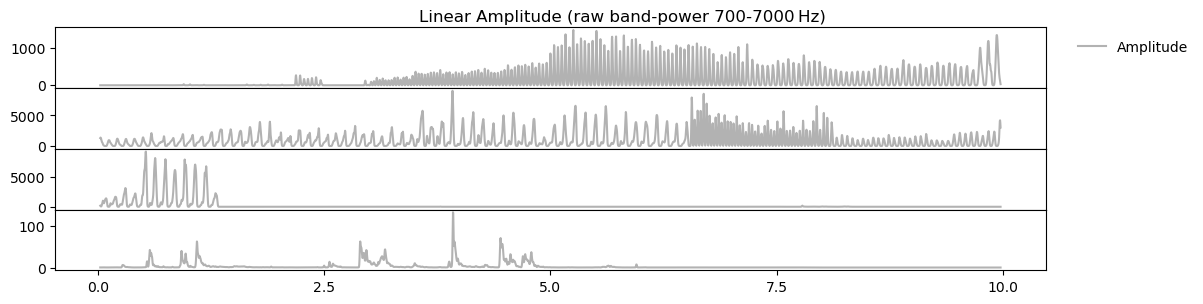

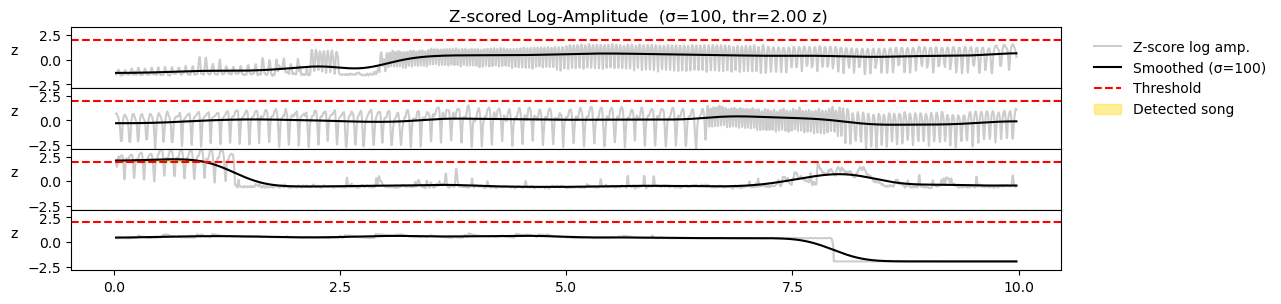

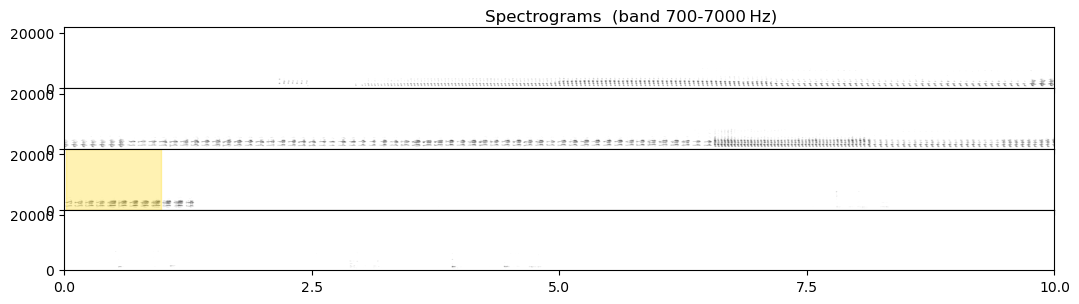


Detected song intervals (s):
     20.02 –    20.98


In [4]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ───────────────────────── screen‑size helper ────────────────────────────────
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100        # ≈ inches (100 dpi assumption)

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps               # tiny constant to avoid log(0)

# ─────────────────────── mask → [start, end] helper ──────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ─────────────────────────────── main routine ───────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:
    """
    Visualise a WAV file in stacked panels and detect song using the
    z‑scored *log* amplitude envelope.  Linear amplitude is plotted raw‑only.
    All Z‑score panels share the same y‑limits for easier comparison.
    """

    # ── Load & band‑pass filter ─────────────────────────────────────────────
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ── Segment bookkeeping ─────────────────────────────────────────────────
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ── Create 3 stacked figure groups (no vertical spacing) ────────────────
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_zsc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_zsc, axs_spc = [axs_lin], [axs_zsc], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # 🔸 MOD – track global min/max for y‑limits
    global_min_z, global_max_z = np.inf, -np.inf

    # ── Per‑segment processing ──────────────────────────────────────────────
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # ── Spectrogram ─────────────────────────────────────────────────────
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # ── Band‑power amplitude ───────────────────────────────────────────
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_log = (10 * np.log10(amp + eps) if log_base == 10
                   else np.log(amp + eps))

        # ── Z‑score, smooth & threshold ────────────────────────────────────
        amp_log_z = (amp_log - amp_log.mean()) / (amp_log.std() + eps)
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)

        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # 🔸 MOD – update global min/max
        local_min = min(amp_log_z.min(), amp_log_z_s.min(), threshold_log)
        local_max = max(amp_log_z.max(), amp_log_z_s.max(), threshold_log)
        global_min_z = min(global_min_z, local_min)
        global_max_z = max(global_max_z, local_max)

        # ── Plot ① Linear amplitude (raw only) ─────────────────────────────
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ② Z‑scored log envelope ───────────────────────────────────
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i == 0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i == 0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ③ Spectrogram ─────────────────────────────────────────────
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))

    # 🔸 MOD – apply common y‑limits to every Z‑score axis
    for ax in axs_zsc:
        ax.set_ylim(global_min_z, global_max_z)

    # ── Titles & layout ────────────────────────────────────────────────────
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude (raw band‑power {bp})', fontsize=12)
    fig2.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, '
                  f'thr={threshold_log:.2f} z)', fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)

    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    # ── Console output ────────────────────────────────────────────────────
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma_log=100,
            threshold_log=2.0   # z‑score units
        )
    else:
        print("Example WAV not found:", wav_path)


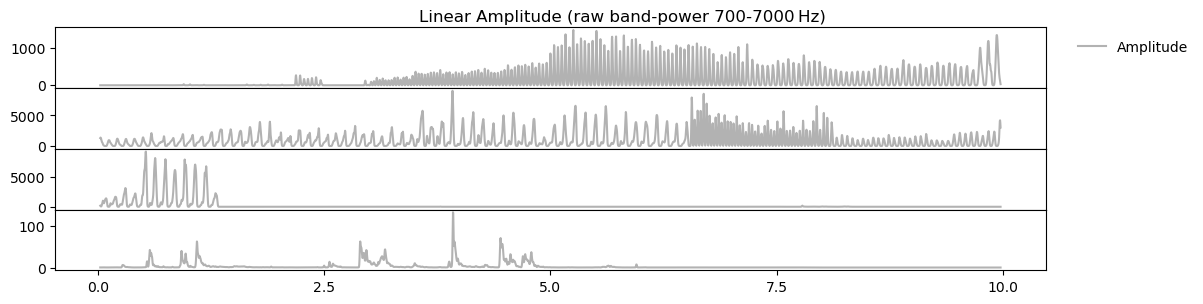

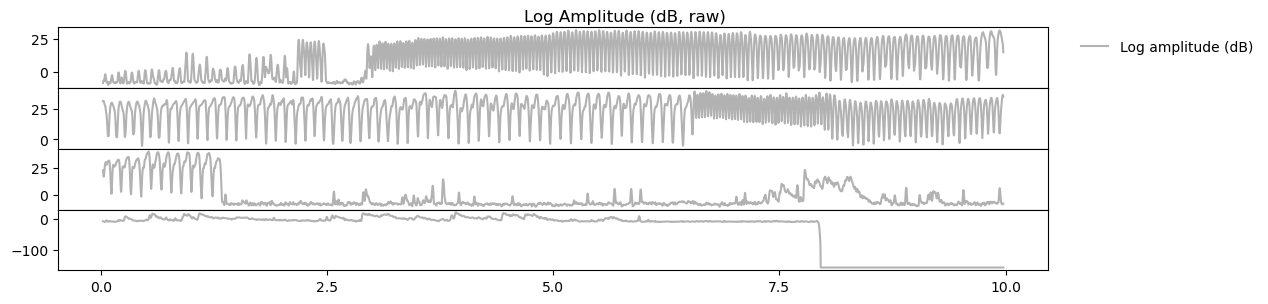

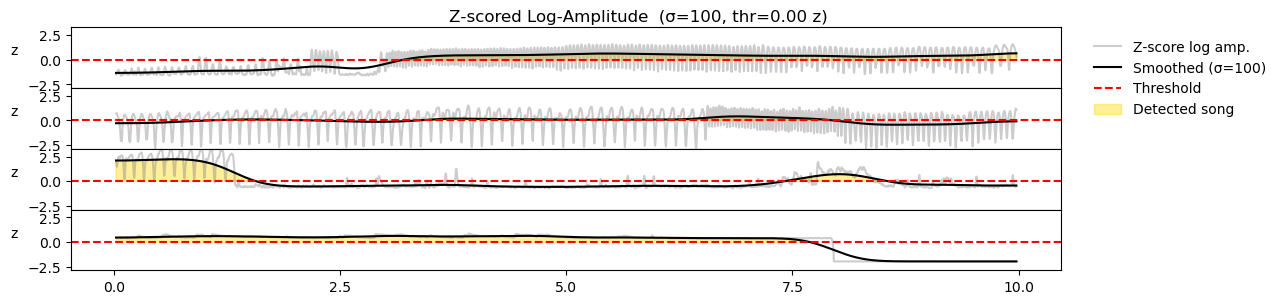

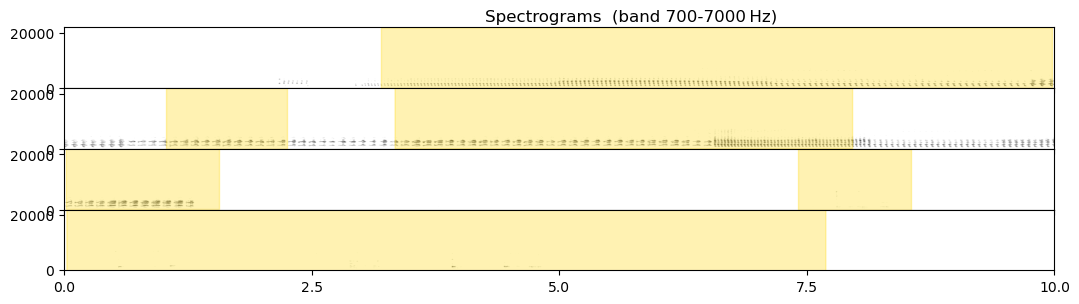


Detected song intervals (s):
      3.20 –     9.97
     11.03 –    12.25
     13.34 –    17.96
     20.02 –    21.57
     27.41 –    28.55
     30.02 –    37.69


In [12]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ───────────────────────── screen‑size helper ────────────────────────────────
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100        # ≈ inches (100 dpi assumption)

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps               # tiny constant to avoid log(0)

# ─────────────────────── mask → [start, end] helper ──────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ─────────────────────────────── main routine ───────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:
    """
    Visualise a WAV file in stacked panels and detect song using the
    z‑scored *log* amplitude envelope.  Linear amplitude and raw log
    amplitude are plotted for reference (no smoothing / threshold).
    All Z‑score panels share the same y‑limits.
    """

    # ── Load & band‑pass filter ─────────────────────────────────────────────
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ── Segment bookkeeping ─────────────────────────────────────────────────
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ── Create 4 stacked figure groups (no vertical spacing) ────────────────
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),  # 🔸 NEW
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_zsc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig4, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_zsc, axs_spc = \
            [axs_lin], [axs_log], [axs_zsc], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # 🔸 MOD – track global min/max for y‑limits of z‑score plot
    global_min_z, global_max_z = np.inf, -np.inf

    # ── Per‑segment processing ──────────────────────────────────────────────
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # ── Spectrogram ─────────────────────────────────────────────────────
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # ── Band‑power amplitude (linear + log) ────────────────────────────
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)                    # linear
        amp_log = (10 * np.log10(amp + eps) if log_base == 10   # raw log‑dB
                   else np.log(amp + eps))

        # ── Z‑score, smooth & threshold (for detection) ────────────────────
        amp_log_z = (amp_log - amp_log.mean()) / (amp_log.std() + eps)
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)

        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # 🔸 Update global min/max for z‑score y‑limits
        local_min = min(amp_log_z.min(), amp_log_z_s.min(), threshold_log)
        local_max = max(amp_log_z.max(), amp_log_z_s.max(), threshold_log)
        global_min_z = min(global_min_z, local_min)
        global_max_z = max(global_max_z, local_max)

        # ── Plot ① Linear amplitude (raw) ──────────────────────────────────
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 🔸 Plot ② Log amplitude (raw dB) ──────────────────────────────────
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.6,
                  label='Log amplitude (dB)' if i == 0 else None)
        axLg.set_xticks([] if i < n_seg - 1 else
                        np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ③ Z‑scored log envelope ───────────────────────────────────
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i == 0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i == 0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ④ Spectrogram ─────────────────────────────────────────────
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))

    # ── Apply common y‑limits to every Z‑score axis ─────────────────────────
    for ax in axs_zsc:
        ax.set_ylim(global_min_z, global_max_z)

    # ── Titles & layout ────────────────────────────────────────────────────
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude (raw band‑power {bp})', fontsize=12)
    fig2.suptitle('Log Amplitude (dB, raw)', fontsize=12)               # 🔸 NEW
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, '
                  f'thr={threshold_log:.2f} z)', fontsize=12)
    fig4.suptitle(f'Spectrograms  (band {bp})', fontsize=12)

    for fig in (fig1, fig2, fig3, fig4):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    # ── Console output ────────────────────────────────────────────────────
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma_log=100,
            threshold_log=0   # z‑score units
        )
    else:
        print("Example WAV not found:", wav_path)


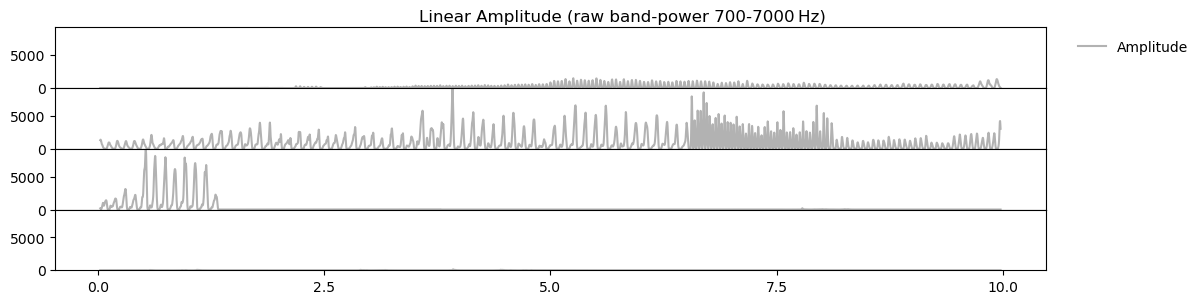

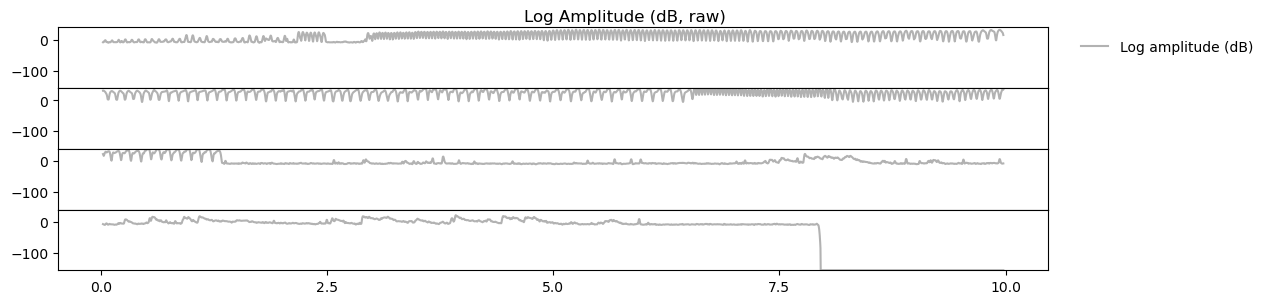

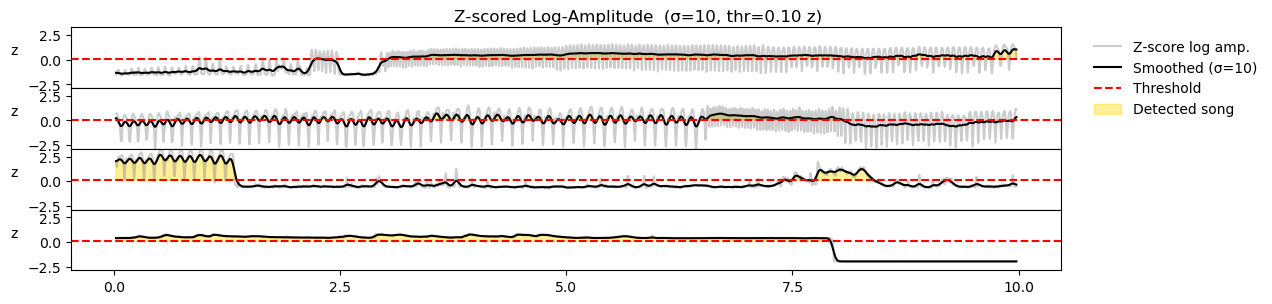

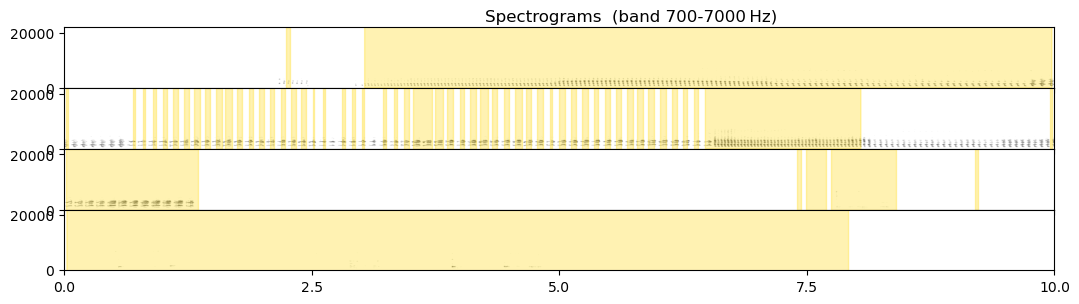


Detected song intervals (s):
      2.24 –     2.28
      3.03 –     9.97
     10.02 –    10.04
     10.69 –    10.72
     10.79 –    10.82
     10.90 –    10.94
     11.00 –    11.05
     11.10 –    11.15
     11.21 –    11.26
     11.31 –    11.37
     11.42 –    11.47
     11.53 –    11.59
     11.63 –    11.70
     11.74 –    11.80
     11.87 –    11.91
     11.97 –    12.02
     12.08 –    12.12
     12.19 –    12.24
     12.30 –    12.35
     12.39 –    12.44
     12.51 –    12.52
     12.61 –    12.63
     12.80 –    12.84
     12.91 –    12.94
     13.01 –    13.03
     13.22 –    13.25
     13.33 –    13.36
     13.43 –    13.48
     13.53 –    13.72
     13.75 –    13.83
     13.87 –    13.93
     14.00 –    14.04
     14.10 –    14.17
     14.20 –    14.28
     14.32 –    14.38
     14.44 –    14.50
     14.55 –    14.62
     14.66 –    14.72
     14.78 –    14.83
     14.90 –    14.93
     15.00 –    15.06
     15.12 –    15.17
     15.23 –    15.29
     15.35 –    15.40
  

In [15]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ───────────────────────── screen‑size helper ────────────────────────────────
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100        # ≈ inches (100 dpi assumption)

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps               # tiny constant to avoid log(0)

# ─────────────────────── mask → [start, end] helper ──────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ─────────────────────────────── main routine ───────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:
    """
    Visualise a WAV file in stacked panels and detect song using the
    z‑scored *log* amplitude envelope.  Linear amplitude and raw log
    amplitude are plotted for reference (no smoothing / threshold).
    All panels within each stack share the same y‑limits.
    """

    # ── Load & band‑pass filter ─────────────────────────────────────────────
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ── Segment bookkeeping ─────────────────────────────────────────────────
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ── Create 4 stacked figure groups (no vertical spacing) ────────────────
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_zsc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig4, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_zsc, axs_spc = \
            [axs_lin], [axs_log], [axs_zsc], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ── Track global min/max for y‑limits ───────────────────────────────────
    global_min_lin, global_max_lin = np.inf, -np.inf
    global_min_log, global_max_log = np.inf, -np.inf
    global_min_z,   global_max_z   = np.inf, -np.inf   # already used earlier

    # ── Per‑segment processing ──────────────────────────────────────────────
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # ── Spectrogram ─────────────────────────────────────────────────────
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # ── Band‑power amplitude (linear + log) ────────────────────────────
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)                    # linear
        amp_log = (10 * np.log10(amp + eps) if log_base == 10   # raw log‑dB
                   else np.log(amp + eps))

        # ── Z‑score, smooth & threshold (for detection) ────────────────────
        amp_log_z = (amp_log - amp_log.mean()) / (amp_log.std() + eps)
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)

        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log
        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ── Update global y‑limits ─────────────────────────────────────────
        global_min_lin = min(global_min_lin, amp.min())
        global_max_lin = max(global_max_lin, amp.max())
        global_min_log = min(global_min_log, amp_log.min())
        global_max_log = max(global_max_log, amp_log.max())
        global_min_z   = min(global_min_z, amp_log_z.min(), amp_log_z_s.min(),
                             threshold_log)
        global_max_z   = max(global_max_z, amp_log_z.max(), amp_log_z_s.max(),
                             threshold_log)

        # ── Plot ① Linear amplitude (raw) ──────────────────────────────────
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ② Log amplitude (raw dB) ──────────────────────────────────
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.6,
                  label='Log amplitude (dB)' if i == 0 else None)
        axLg.set_xticks([] if i < n_seg - 1 else
                        np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ③ Z‑scored log envelope ───────────────────────────────────
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i == 0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i == 0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ── Plot ④ Spectrogram ─────────────────────────────────────────────
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else
                       np.linspace(0, segment_duration, 5))

    # ── Apply shared y‑limits ───────────────────────────────────────────────
    for ax in axs_lin:
        ax.set_ylim(global_min_lin, global_max_lin)
    for ax in axs_log:
        ax.set_ylim(global_min_log, global_max_log)
    for ax in axs_zsc:
        ax.set_ylim(global_min_z, global_max_z)

    # ── Titles & layout ────────────────────────────────────────────────────
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude (raw band‑power {bp})', fontsize=12)
    fig2.suptitle('Log Amplitude (dB, raw)', fontsize=12)
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, '
                  f'thr={threshold_log:.2f} z)', fontsize=12)
    fig4.suptitle(f'Spectrograms  (band {bp})', fontsize=12)

    for fig in (fig1, fig2, fig3, fig4):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    # ── Console output ────────────────────────────────────────────────────
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma_log=10,
            threshold_log=0.1   # z‑score units
        )
    else:
        print("Example WAV not found:", wav_path)


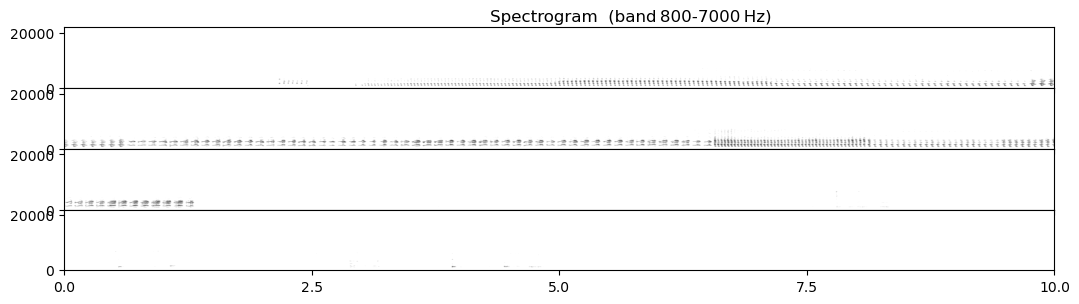

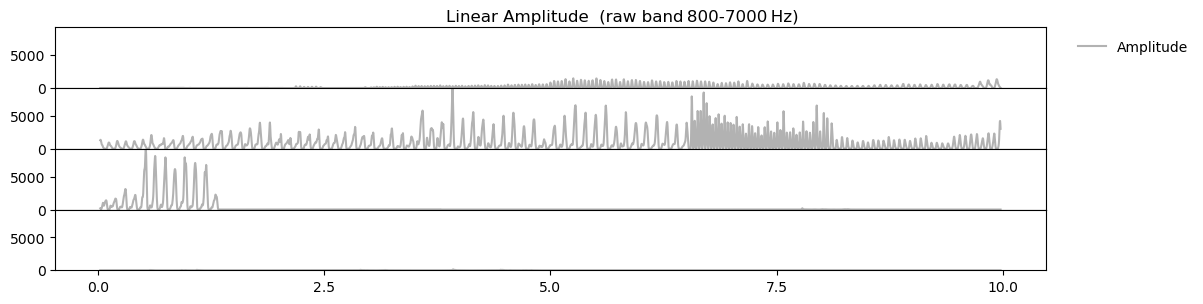

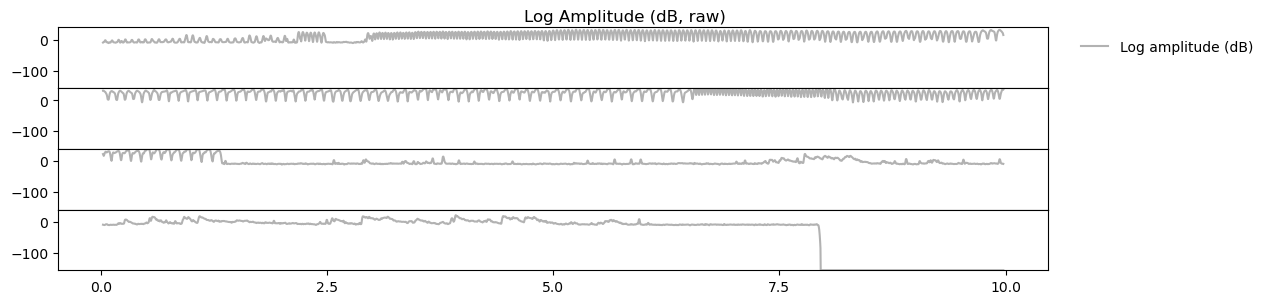

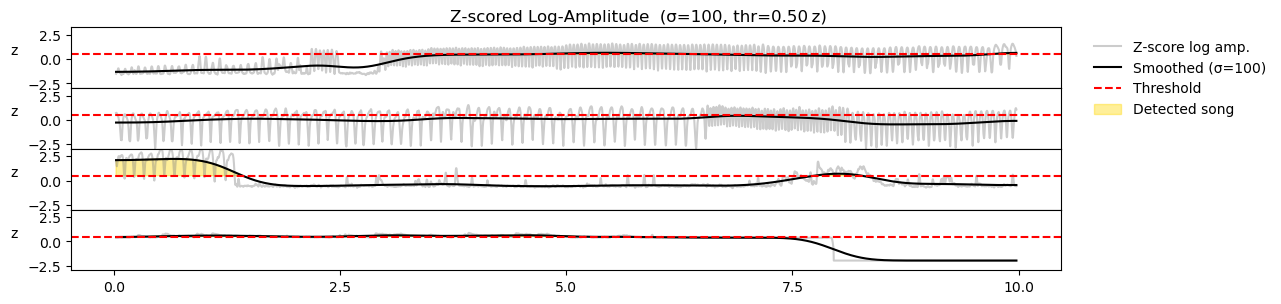

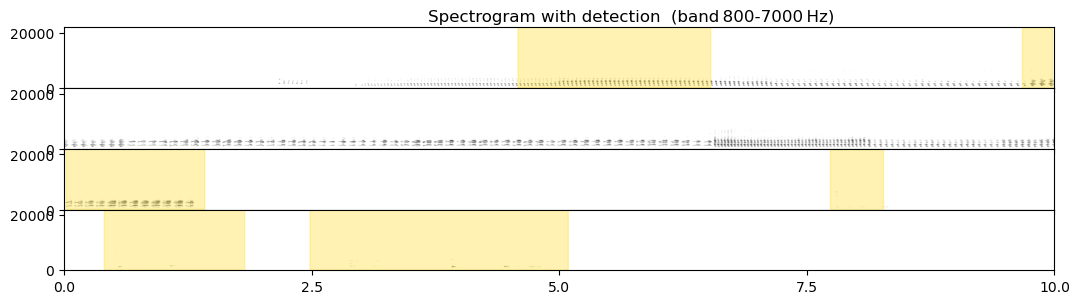


Detected song intervals (s):
      4.58 –     6.53
      9.67 –     9.97
     20.02 –    21.42
     27.74 –    28.27
     30.41 –    31.83
     32.48 –    35.09


In [18]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset)); in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:

    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # 🔸 NEW: raw spectrogram stack (no detection shading)
    fig0, axs_spc_raw = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig1, axs_lin = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig2, axs_log = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig3, axs_zsc = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    # 🔸 RENAMED original bottom spectrogram
    fig4, axs_spc_det = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )

    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_log     = [axs_log]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected: List[Tuple[float, float]] = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_log, gmax_log = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        start = i * seg_len
        seg = data[start:start+seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048, noverlap=2048 - 119
        )
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min())/(Sxx_db.max()-Sxx_db.min())

        # Band‑power envelopes
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp     = np.sum(Sxx[rows,:], axis=0)
        amp_log = (10*np.log10(amp+eps) if log_base==10 else np.log(amp+eps))

        # Z‑score → smooth → threshold
        amp_log_z   = (amp_log - amp_log.mean())/(amp_log.std()+eps)
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)
        if threshold_log is None and i==0:
            threshold_log = np.percentile(amp_log_z_s,90)
        mask_log = amp_log_z_s > threshold_log
        detected.extend(mask_to_intervals(mask_log, t, i*segment_duration))

        # Update global y‑limits
        gmin_lin = min(gmin_lin, amp.min());    gmax_lin = max(gmax_lin, amp.max())
        gmin_log = min(gmin_log, amp_log.min());gmax_log = max(gmax_log, amp_log.max())
        gmin_z   = min(gmin_z, amp_log_z.min(), amp_log_z_s.min(), threshold_log)
        gmax_z   = max(gmax_z, amp_log_z.max(), amp_log_z_s.max(), threshold_log)

        # 🔸 Raw spectrogram (no shading)
        axR = axs_spc_raw[i]
        axR.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axR.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

        # Linear amplitude
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i==0 else None)
        axL.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02,1.0), frameon=False)

        # Raw log amplitude
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.6,
                  label='Log amplitude (dB)' if i==0 else None)
        axLg.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02,1.0), frameon=False)

        # Z‑scored log
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i==0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i==0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i==0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i==0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02,1.0), frameon=False)

        # 🔸 Bottom spectrogram with detected‑song shading
        axS = axs_spc_det[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

    # Apply shared y‑limits
    for ax in axs_lin: ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_log: ax.set_ylim(gmin_log, gmax_log)
    for ax in axs_zsc: ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (raw band {bp})', fontsize=12)
    fig2.suptitle('Log Amplitude (dB, raw)', fontsize=12)
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, thr={threshold_log:.2f} z)',
                  fontsize=12)
    fig4.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig in (fig0, fig1, fig2, fig3, fig4):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s,e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=800,
            bandpass_filter_high_cut=7000,
            sigma_log=100,
            threshold_log=0.5
        )
    else:
        print("Example WAV not found:", wav_path)


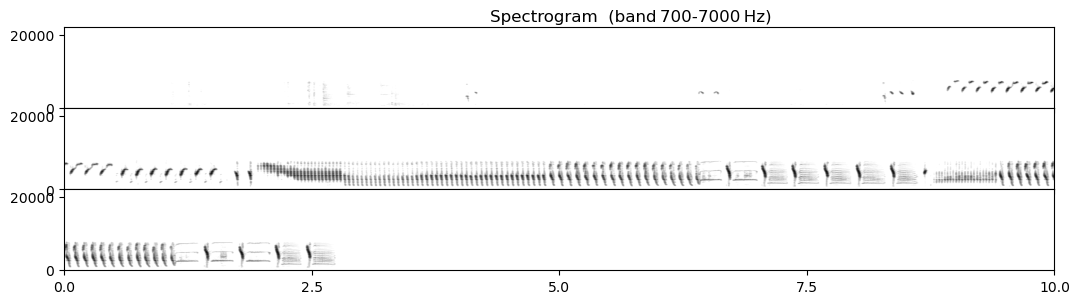

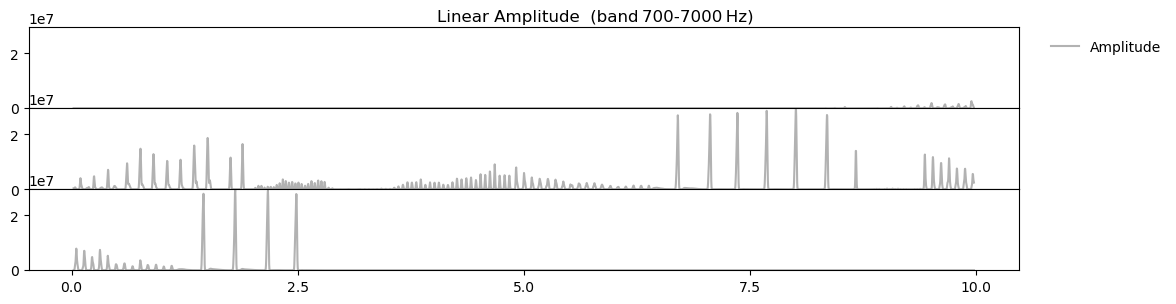

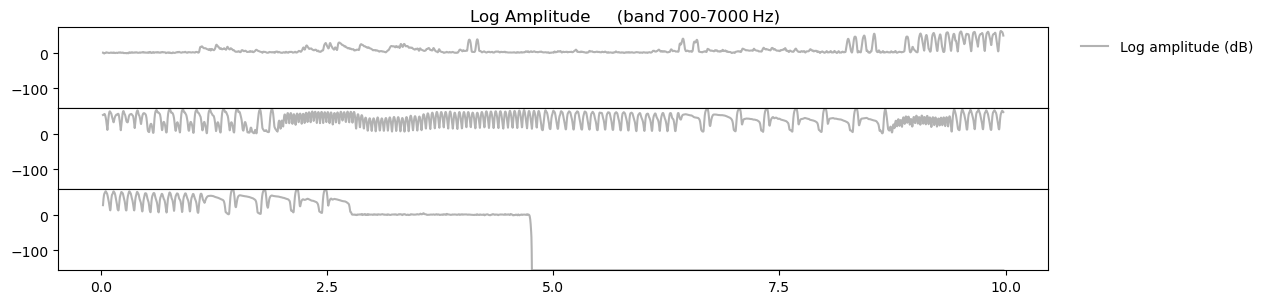

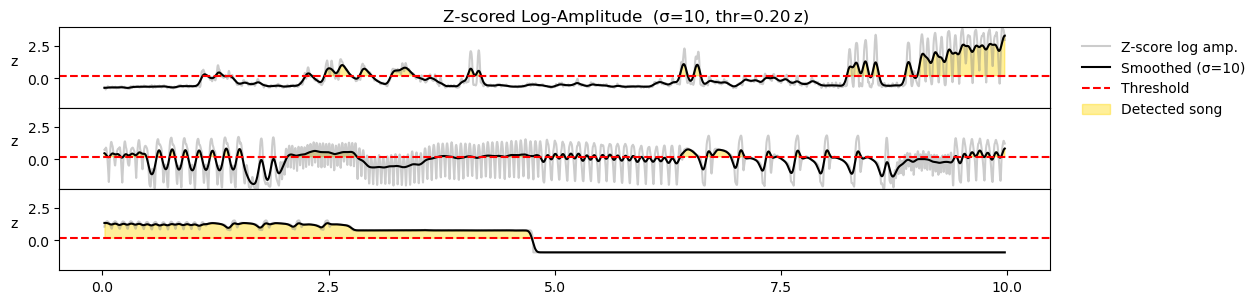

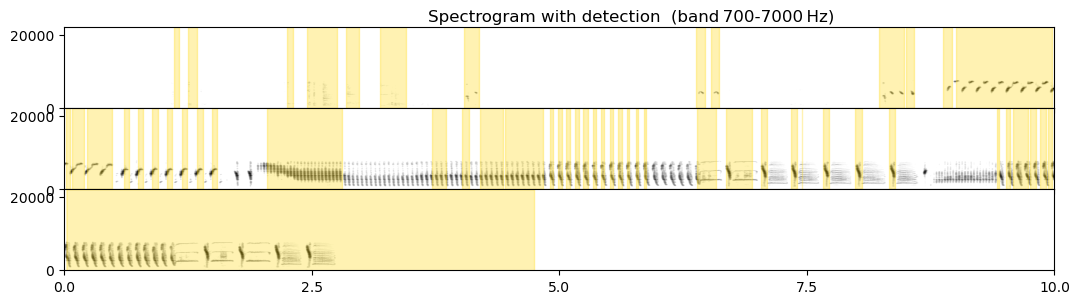


Detected song intervals (s):
      1.11 –     1.16
      1.25 –     1.34
      2.25 –     2.31
      2.45 –     2.75
      2.84 –     2.98
      3.19 –     3.45
      4.04 –     4.19
      6.38 –     6.47
      6.53 –     6.62
      8.23 –     8.48
      8.50 –     8.59
      8.87 –     8.97
      9.01 –     9.97
     10.02 –    10.06
     10.08 –    10.20
     10.23 –    10.49
     10.60 –    10.66
     10.75 –    10.80
     10.89 –    10.95
     11.04 –    11.10
     11.19 –    11.25
     11.34 –    11.40
     11.49 –    11.55
     12.05 –    12.81
     13.71 –    13.86
     14.02 –    14.09
     14.19 –    14.44
     14.46 –    14.84
     14.91 –    14.94
     14.99 –    15.03
     15.07 –    15.12
     15.16 –    15.21
     15.24 –    15.29
     15.34 –    15.37
     15.42 –    15.46
     15.51 –    15.55
     15.59 –    15.63
     15.68 –    15.71
     15.77 –    15.80
     15.86 –    15.88
     16.39 –    16.58
     16.68 –    16.95
     17.04 –    17.10
     17.34 –    17.40
  

In [34]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:

    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # create figures for each panel
    fig0, axs_spc_raw = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig1, axs_lin     = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig2, axs_log     = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig3, axs_zsc     = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig4, axs_spc_det = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )

    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_log     = [axs_log]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_log, gmax_log = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        start = i * seg_len
        seg = data[start:start+seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))

        # compute spectrogram
        f, t, Sxx = spectrogram(
            seg, fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048, noverlap=2048-119
        )
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # band‑power envelope
        rows    = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp     = np.sum(Sxx[rows, :], axis=0)
        amp_log = (10*np.log10(amp + eps) if log_base==10 else np.log(amp + eps))

        # z‑score → smooth → threshold
        amp_log_z   = (amp_log - amp_log.mean())/(amp_log.std()+eps)
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log
        detected.extend(mask_to_intervals(mask_log, t, i*segment_duration))

        # update global minima/maxima
        gmin_lin = min(gmin_lin, amp.min());      gmax_lin = max(gmax_lin, amp.max())
        gmin_log = min(gmin_log, amp_log.min());  gmax_log = max(gmax_log, amp_log.max())
        gmin_z   = min(gmin_z, amp_log_z.min(), amp_log_z_s.min(), threshold_log)
        gmax_z   = max(gmax_z, amp_log_z.max(), amp_log_z_s.max(), threshold_log)

        # 1) raw spectrogram
        axR = axs_spc_raw[i]
        axR.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axR.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))

        # 2) linear amplitude
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 3) log amplitude
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.6,
                  label='Log amplitude (dB)' if i == 0 else None)
        axLg.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 4) z‑scored log + smoothing + detection shading
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i == 0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i == 0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 5) spectrogram + detection shading
        axS = axs_spc_det[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))

    # apply shared y‑limits using exact data minima/maxima
    for ax in axs_lin:
        ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_log:
        ax.set_ylim(gmin_log, gmax_log)
    for ax in axs_zsc:
        ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle(f'Log Amplitude     (band {bp})', fontsize=12)
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, thr={threshold_log:.2f} z)',
                  fontsize=12)
    fig4.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig in (fig0, fig1, fig2, fig3, fig4):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma_log=10,
            threshold_log=0.2
        )
    else:
        print("Example WAV not found:", wav_path)


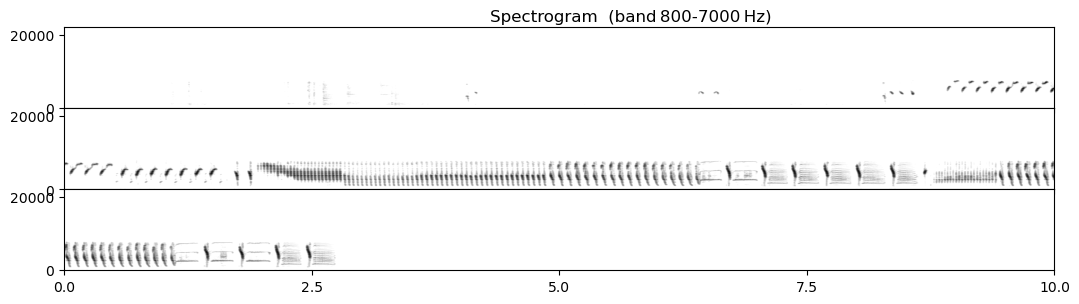

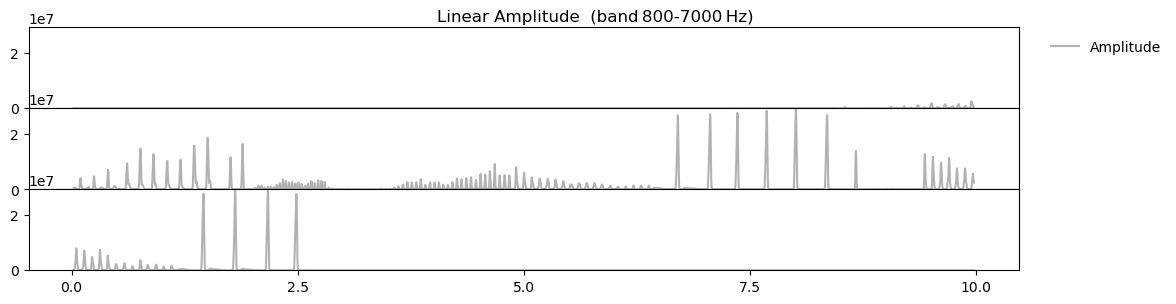

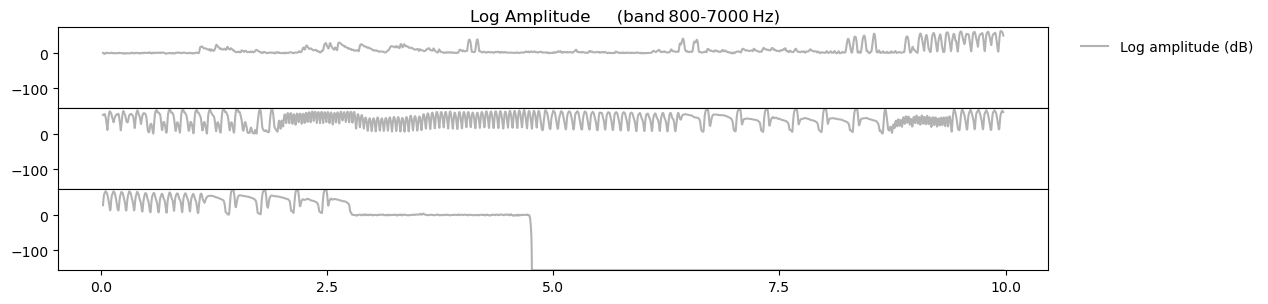

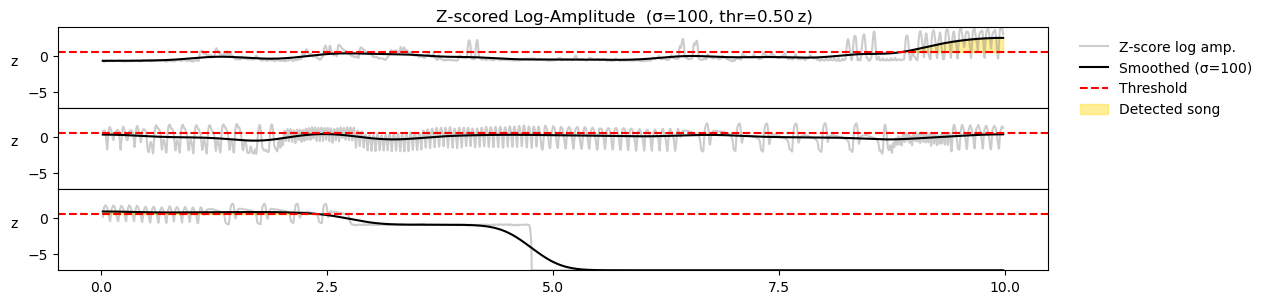

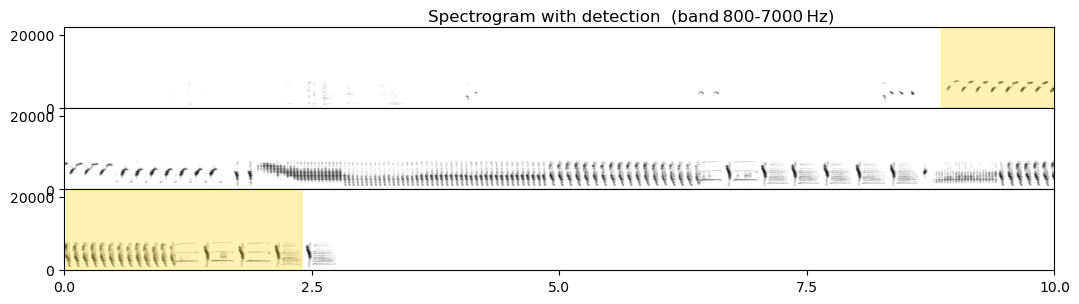


Detected song intervals (s):
      8.86 –     9.97
     20.02 –    22.40


In [36]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:

    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # create figures for each panel
    fig0, axs_spc_raw = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig1, axs_lin     = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig2, axs_log     = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig3, axs_zsc     = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )
    fig4, axs_spc_det = plt.subplots(n_seg, 1,
        figsize=(width_inches, 3), sharex=True,
        gridspec_kw={"hspace": 0}
    )

    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_log     = [axs_log]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_log, gmax_log = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        seg = data[i*seg_len : i*seg_len + seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))

        # Spectrogram
        f, t, Sxx = spectrogram(
            seg, fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048, noverlap=2048-119
        )
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Band‑power envelope
        rows    = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp     = np.sum(Sxx[rows, :], axis=0)
        amp_log = (10*np.log10(amp + eps) if log_base==10 else np.log(amp + eps))

        # Z‑score on valid (non‑zero) log‑amplitude bins only
        valid      = amp > eps
        mean_valid = amp_log[valid].mean()
        std_valid  = amp_log[valid].std() + eps
        amp_log_z  = (amp_log - mean_valid) / std_valid

        # Smooth & threshold
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log
        detected.extend(mask_to_intervals(mask_log, t, i*segment_duration))

        # update global minima/maxima
        gmin_lin = min(gmin_lin, amp.min());      gmax_lin = max(gmax_lin, amp.max())
        gmin_log = min(gmin_log, amp_log.min());  gmax_log = max(gmax_log, amp_log.max())
        gmin_z   = min(gmin_z, amp_log_z.min(), amp_log_z_s.min(), threshold_log)
        gmax_z   = max(gmax_z, amp_log_z.max(), amp_log_z_s.max(), threshold_log)

        # 1) Raw spectrogram
        axR = axs_spc_raw[i]
        axR.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axR.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))

        # 2) Linear amplitude
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 3) Log amplitude
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.6,
                  label='Log amplitude (dB)' if i == 0 else None)
        axLg.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 4) Z‑scored log + smoothing + detection shading
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i == 0 else None)
        axZ.plot(t, amp_log_z_s, color='black',
                 label=f'Smoothed (σ={sigma_log})' if i == 0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 5) Spectrogram with detection shading
        axS = axs_spc_det[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))

    # Apply shared y‑limits
    for ax in axs_lin:
        ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_log:
        ax.set_ylim(gmin_log, gmax_log)
    for ax in axs_zsc:
        ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle(f'Log Amplitude     (band {bp})', fontsize=12)
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, thr={threshold_log:.2f} z)',
                  fontsize=12)
    fig4.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig in (fig0, fig1, fig2, fig3, fig4):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=800,
            bandpass_filter_high_cut=7000,
            sigma_log=100,
            threshold_log=0.5
        )
    else:
        print("Example WAV not found:", wav_path)


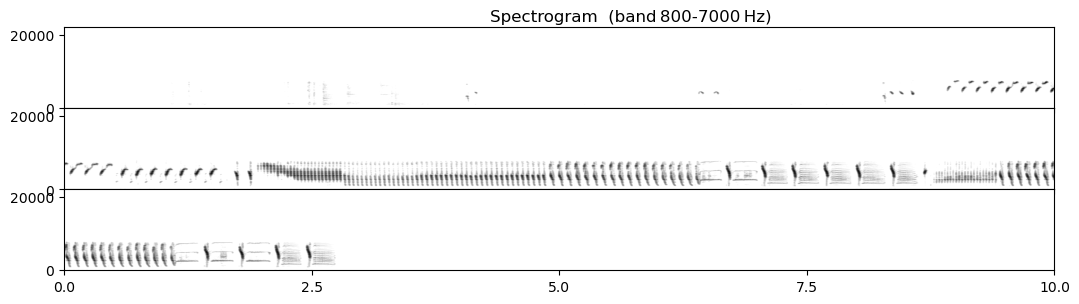

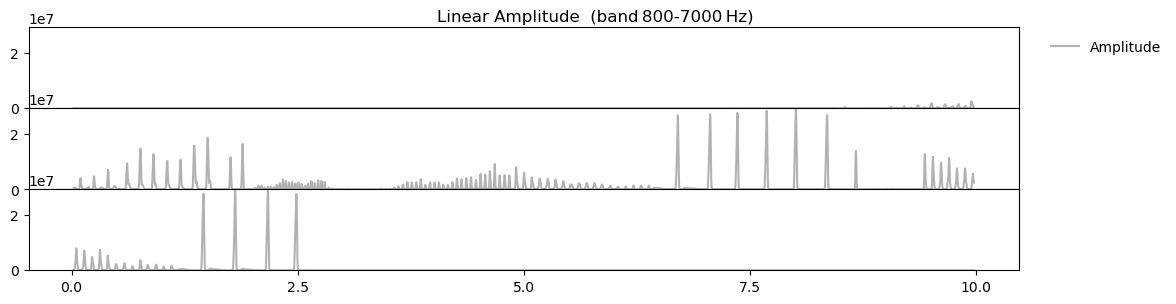

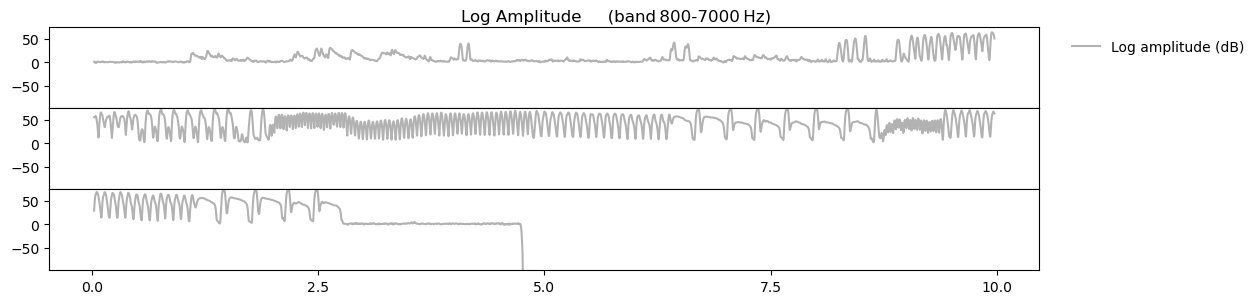

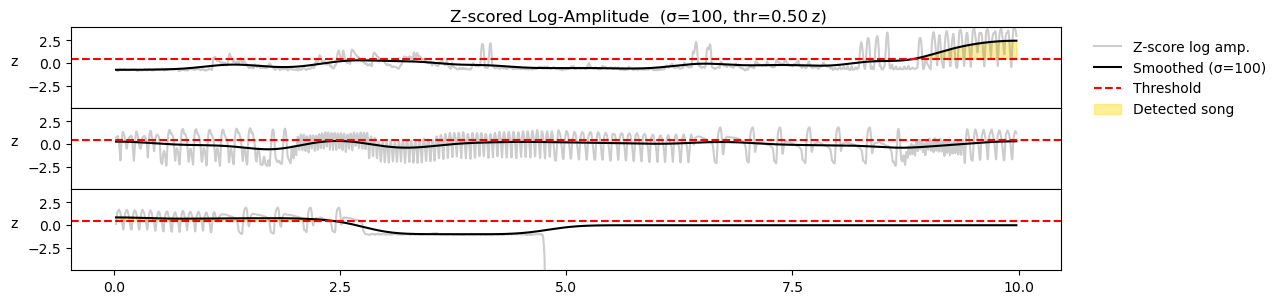

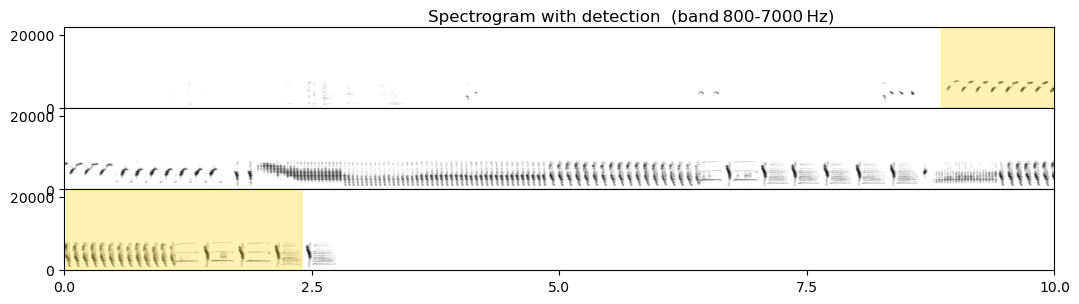


Detected song intervals (s):
      8.86 –     9.97
     20.02 –    22.40


In [2]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:

    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    # design & apply band‑pass filter
    wp = [bandpass_filter_low_cut / (sr/2), bandpass_filter_high_cut / (sr/2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # prepare figures
    figs = [plt.subplots(n_seg, 1, figsize=(width_inches, 3), sharex=True, gridspec_kw={"hspace": 0})
            for _ in range(5)]
    (fig0, axs_spc_raw), (fig1, axs_lin), (fig2, axs_log), \
    (fig3, axs_zsc),   (fig4, axs_spc_det) = figs

    # ensure list of axes
    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_log     = [axs_log]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_log, gmax_log = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        seg = data[i*seg_len : i*seg_len + seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))

        # compute spectrogram
        f, t, Sxx = spectrogram(
            seg, fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048, noverlap=2048-119
        )
        Sxx_db = 10*np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min())/(Sxx_db.max()-Sxx_db.min())

        # band‑power envelope
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp  = np.sum(Sxx[rows, :], axis=0)

        # compute log amplitude and mask zeros → NaN
        amp_log = (10*np.log10(amp + eps) if log_base==10 else np.log(amp + eps))
        amp_log[amp <= eps] = np.nan

        # z‑score on non‑NaN only
        mean_valid = np.nanmean(amp_log)
        std_valid  = np.nanstd(amp_log) + eps
        amp_log_z  = (amp_log - mean_valid)/std_valid

        # smooth & threshold
        amp_log_z_s = gaussian_filter1d(np.nan_to_num(amp_log_z, nan=0.0), sigma=sigma_log)
        if threshold_log is None and i==0:
            threshold_log = np.nanpercentile(amp_log_z_s, 90)
        mask_log = amp_log_z_s > threshold_log
        detected.extend(mask_to_intervals(mask_log, t, i*segment_duration))

        # update global limits
        gmin_lin = min(gmin_lin, amp.min());      gmax_lin = max(gmax_lin, amp.max())
        gmin_log = min(gmin_log, np.nanmin(amp_log)); gmax_log = max(gmax_log, np.nanmax(amp_log))
        gmin_z   = min(gmin_z, np.nanmin(amp_log_z), np.nanmin(amp_log_z_s), threshold_log)
        gmax_z   = max(gmax_z, np.nanmax(amp_log_z), np.nanmax(amp_log_z_s), threshold_log)

        # 1) raw spectrogram
        axR = axs_spc_raw[i]
        axR.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
        axR.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

        # 2) linear amplitude
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6, label='Amplitude' if i==0 else None)
        axL.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axL.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02,1.0), frameon=False)

        # 3) log amplitude – plot only non‑NaN points
        axLg = axs_log[i]
        valid = ~np.isnan(amp_log)
        if valid.any():
            axLg.plot(t[valid], amp_log[valid], color='gray', alpha=0.6,
                       label='Log amplitude (dB)' if i==0 else None)
        axLg.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axLg.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02,1.0), frameon=False)

        # 4) z‑scored log
        axZ = axs_zsc[i]
        axZ.plot(t, amp_log_z, color='gray', alpha=0.4, label='Z‑score log amp.' if i==0 else None)
        axZ.plot(t, amp_log_z_s, color='black', label=f'Smoothed (σ={sigma_log})' if i==0 else None)
        axZ.axhline(threshold_log, color='red', ls='--', label='Threshold' if i==0 else None)
        axZ.fill_between(t, amp_log_z_s, threshold_log, where=mask_log, color='gold', alpha=0.4,
                         label='Detected song' if i==0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axZ.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02,1.0), frameon=False)

        # 5) spectrogram + detection shading
        axS = axs_spc_det[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

    # apply shared y‑limits
    for ax in axs_lin: ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_log: ax.set_ylim(gmin_log, gmax_log)
    for ax in axs_zsc: ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle(f'Log Amplitude     (band {bp})', fontsize=12)
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, thr={threshold_log:.2f} z)', fontsize=12)
    fig4.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig, _ in figs:
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=800,
            bandpass_filter_high_cut=7000,
            sigma_log=100,
            threshold_log=0.5
        )
    else:
        print("Example WAV not found:", wav_path)


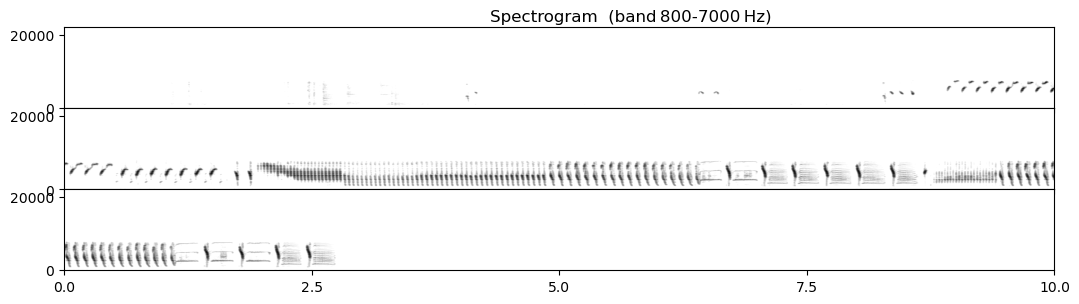

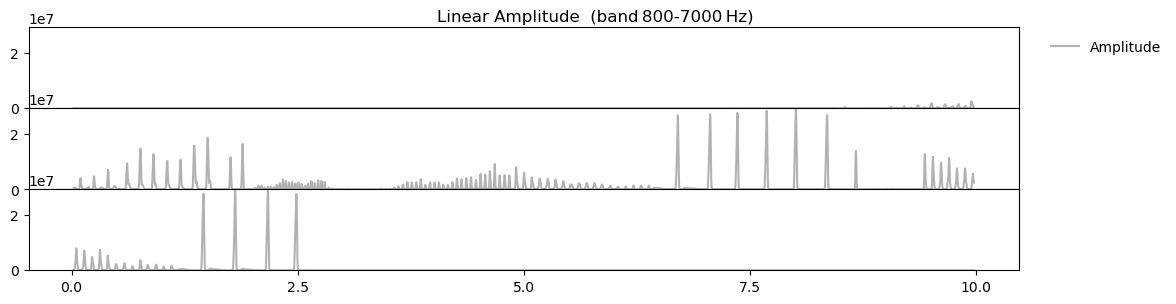

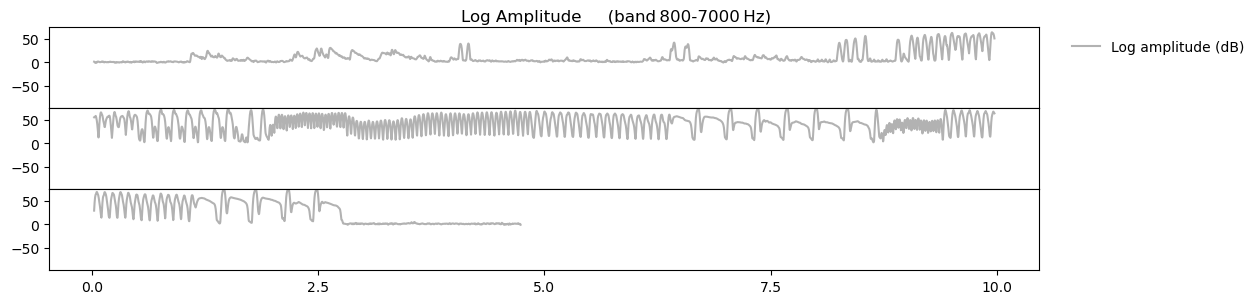

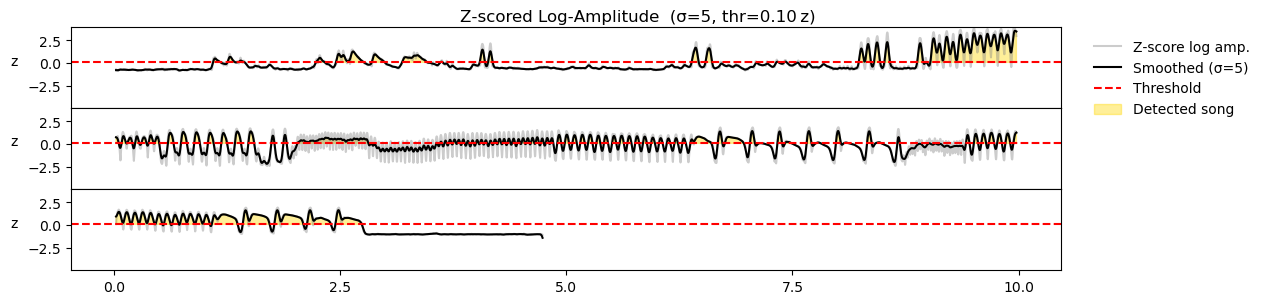

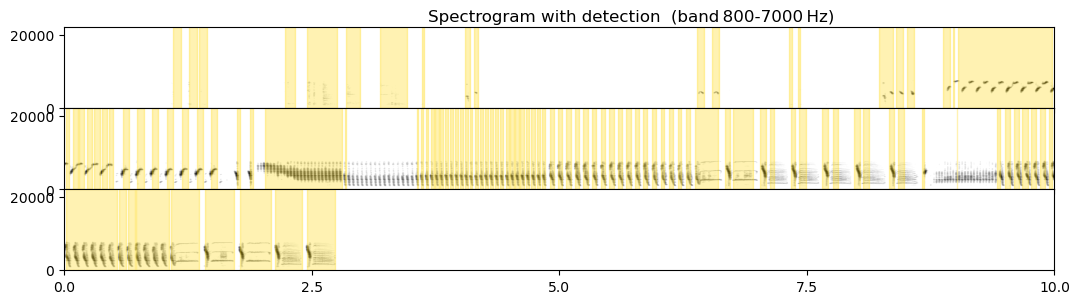


Detected song intervals (s):
      1.10 –     1.18
      1.26 –     1.35
      1.36 –     1.45
      2.23 –     2.33
      2.45 –     2.76
      2.85 –     2.99
      3.19 –     3.46
      3.61 –     3.63
      4.04 –     4.10
      4.14 –     4.19
      6.39 –     6.46
      6.54 –     6.61
      7.32 –     7.35
      7.41 –     7.44
      8.23 –     8.37
      8.40 –     8.47
      8.52 –     8.58
      8.88 –     8.95
      8.97 –     8.98
      9.03 –     9.97
     10.02 –    10.05
     10.09 –    10.14
     10.15 –    10.20
     10.23 –    10.28
     10.30 –    10.36
     10.38 –    10.44
     10.45 –    10.50
     10.60 –    10.66
     10.74 –    10.81
     10.89 –    10.95
     11.04 –    11.10
     11.19 –    11.25
     11.34 –    11.40
     11.49 –    11.55
     11.74 –    11.77
     11.87 –    11.91
     12.03 –    12.81
     12.84 –    12.85
     13.56 –    13.57
     13.61 –    13.63
     13.65 –    13.68
     13.70 –    13.73
     13.75 –    13.78
     13.80 –    13.83
  

In [12]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: Optional[float] = None,
    log_base: float = 10
) -> List[Tuple[float, float]]:

    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    # design & apply band‑pass filter
    wp = [bandpass_filter_low_cut / (sr/2), bandpass_filter_high_cut / (sr/2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # prepare figures
    figs = [plt.subplots(n_seg, 1, figsize=(width_inches, 3), sharex=True, gridspec_kw={"hspace": 0})
            for _ in range(5)]
    (fig0, axs_spc_raw), (fig1, axs_lin), (fig2, axs_log), \
    (fig3, axs_zsc),   (fig4, axs_spc_det) = figs

    # ensure list of axes
    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_log     = [axs_log]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_log, gmax_log = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        # figure out how many real samples in this segment
        start_sample = i * seg_len
        end_sample   = min((i+1) * seg_len, len(data))
        real_samples = end_sample - start_sample
        real_duration = real_samples / sr

        # extract (and pad) segment for spectrogram
        seg = data[start_sample:start_sample+seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))

        # spectrogram
        f, t, Sxx = spectrogram(
            seg, fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048, noverlap=2048-119
        )
        Sxx_db = 10*np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min())/(Sxx_db.max()-Sxx_db.min())

        # band‑power envelope
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp  = np.sum(Sxx[rows, :], axis=0)

        # compute log‑amplitude and set eps‑only → NaN
        amp_log = (10*np.log10(amp + eps) if log_base==10 else np.log(amp + eps))
        amp_log[amp <= eps] = np.nan

        # z‑score on non‑NaN only
        mean_valid = np.nanmean(amp_log)
        std_valid  = np.nanstd(amp_log) + eps
        amp_log_z  = (amp_log - mean_valid)/std_valid

        # smooth & threshold
        amp_log_z_s = gaussian_filter1d(np.nan_to_num(amp_log_z, nan=0.0), sigma=sigma_log)
        if threshold_log is None and i==0:
            threshold_log = np.nanpercentile(amp_log_z_s, 80) #adjusted from 90 to 80
        mask_log = amp_log_z_s > threshold_log

        detected.extend(
            mask_to_intervals(mask_log, t, i*segment_duration)
        )

        # update global bounds
        gmin_lin = min(gmin_lin, np.nanmin(amp));        gmax_lin = max(gmax_lin, np.nanmax(amp))
        gmin_log = min(gmin_log, np.nanmin(amp_log));    gmax_log = max(gmax_log, np.nanmax(amp_log))
        gmin_z   = min(gmin_z,   np.nanmin(amp_log_z), np.nanmin(amp_log_z_s), threshold_log)
        gmax_z   = max(gmax_z,   np.nanmax(amp_log_z), np.nanmax(amp_log_z_s), threshold_log)

        # 1) raw spectrogram
        axR = axs_spc_raw[i]
        axR.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
        axR.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

        # 2) linear amplitude (plot full segment)
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i==0 else None)
        axL.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02,1.0), frameon=False)

        # 3) log amplitude — only up to real_duration
        axLg = axs_log[i]
        valid = (~np.isnan(amp_log)) & (t < real_duration)
        axLg.plot(t[valid], amp_log[valid], color='gray', alpha=0.6,
                  label='Log amplitude (dB)' if i==0 else None)
        axLg.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02,1.0), frameon=False)

        # 4) z‑scored log — only up to real_duration
        axZ = axs_zsc[i]
        valid_z = (t < real_duration)
        axZ.plot(t[valid_z], amp_log_z[valid_z], color='gray', alpha=0.4,
                 label='Z‑score log amp.' if i==0 else None)
        axZ.plot(t[valid_z], amp_log_z_s[valid_z], color='black',
                 label=f'Smoothed (σ={sigma_log})' if i==0 else None)
        axZ.axhline(threshold_log, color='red', ls='--',
                    label='Threshold' if i==0 else None)
        axZ.fill_between(t[valid_z], amp_log_z_s[valid_z], threshold_log,
                         where=mask_log[valid_z], color='gold', alpha=0.4,
                         label='Detected song' if i==0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02,1.0), frameon=False)

        # 5) spectrogram w/ detection shading
        axS = axs_spc_det[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

    # apply shared y‑limits
    for ax in axs_lin: ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_log: ax.set_ylim(gmin_log, gmax_log)
    for ax in axs_zsc: ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle(f'Log Amplitude     (band {bp})', fontsize=12)
    fig3.suptitle(f'Z‑scored Log‑Amplitude  (σ={sigma_log}, thr={threshold_log:.2f} z)', fontsize=12)
    fig4.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig, _ in figs:
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=800,
            bandpass_filter_high_cut=7000,
            sigma_log=5,
            threshold_log=0.1
        )
    else:
        print("Example WAV not found:", wav_path)


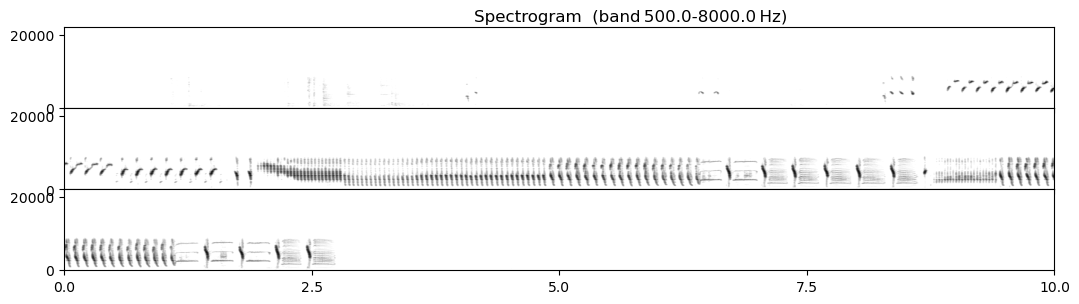

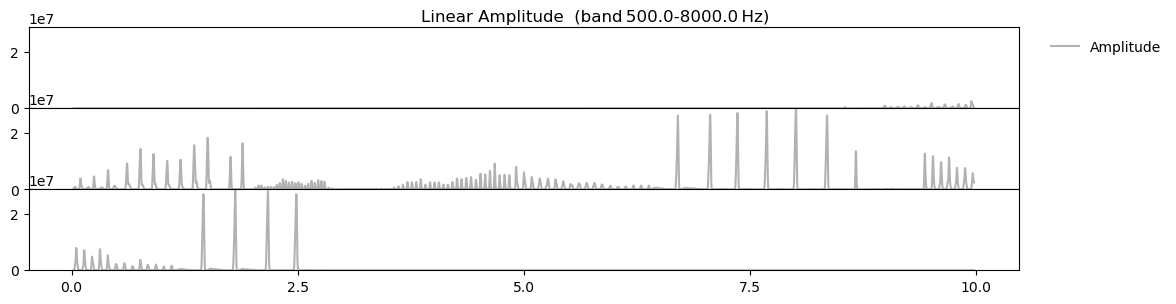

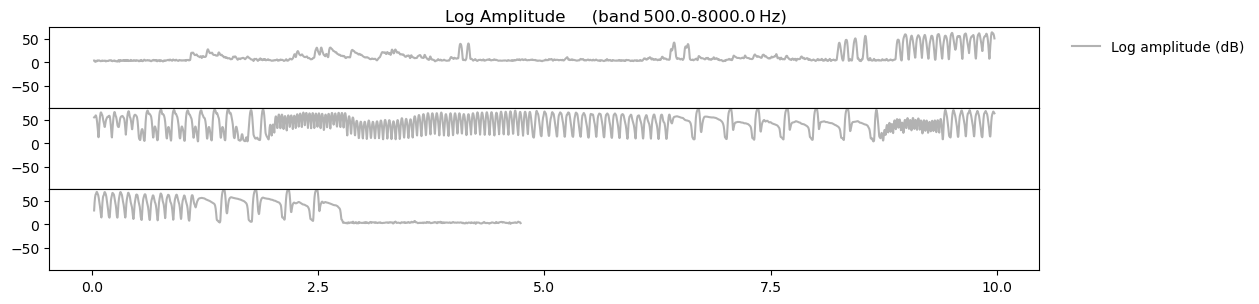

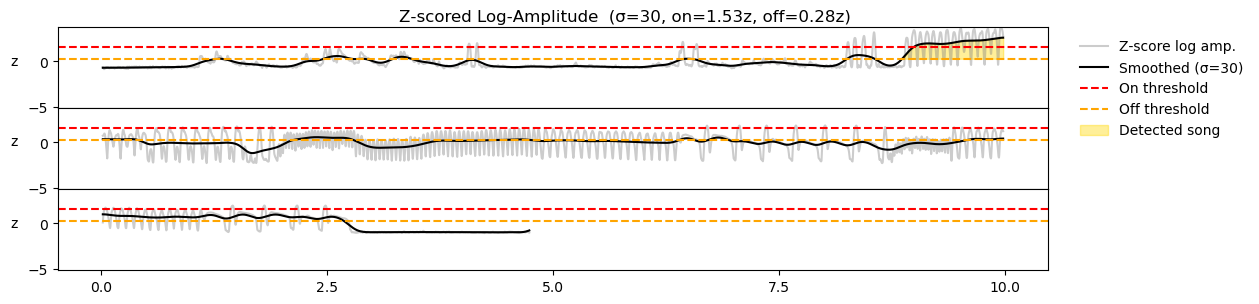

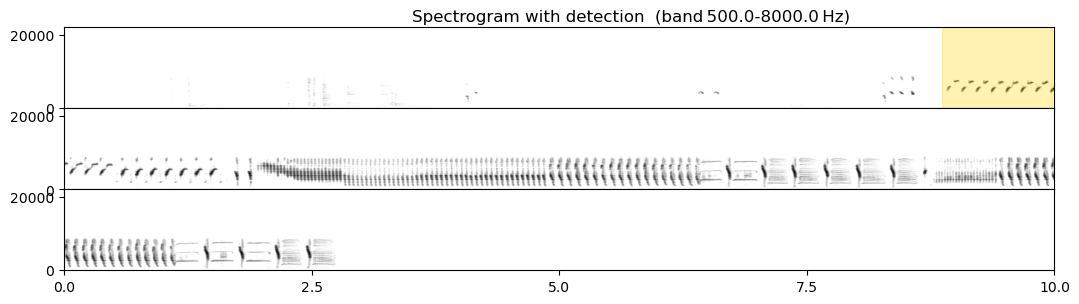


Detected song intervals (s):
      8.86 –     9.97


In [ ]:
# import numpy as np
# from scipy.io import wavfile
# from scipy.signal import spectrogram, windows, ellip, filtfilt
# from scipy.ndimage import gaussian_filter1d
# import matplotlib.pyplot as plt
# import tkinter as tk
# from pathlib import Path
# from typing import List, Tuple, Optional

# def get_screen_resolution() -> Tuple[float, float]:
#     root = tk.Tk(); root.withdraw()
#     w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
#     root.destroy()
#     return w_px / 100, h_px / 100

# eps = np.finfo(float).eps
# width_inches, _ = get_screen_resolution()

# def mask_to_intervals(mask: np.ndarray,
#                       times: np.ndarray,
#                       t_offset: float) -> List[Tuple[float, float]]:
#     intervals = []
#     in_run = False
#     start = 0.0
#     for idx, v in enumerate(mask):
#         if v and not in_run:
#             in_run, start = True, times[idx] + t_offset
#         elif not v and in_run:
#             intervals.append((start, times[idx] + t_offset))
#             in_run = False
#     if in_run:
#         intervals.append((start, times[-1] + t_offset))
#     return intervals

# def hysteresis_mask(env: np.ndarray,
#                     thr_on: float,
#                     thr_off: float) -> np.ndarray:
#     mask = np.zeros_like(env, dtype=bool)
#     above_off = env > thr_off
#     on_idxs = np.where(env > thr_on)[0]
#     for idx in on_idxs:
#         # expand left
#         l = idx
#         while l >= 0 and above_off[l]:
#             mask[l] = True
#             l -= 1
#         # expand right
#         r = idx
#         while r < len(env) and above_off[r]:
#             mask[r] = True
#             r += 1
#     return mask

# def plot_spectrograms_by_segment(
#     file_path: str,
#     segment_duration: float = 10.0,
#     bandpass_filter_low_cut: float = 500.0,
#     bandpass_filter_high_cut: float = 8000.0,
#     sigma_log: float = 30,
#     on_percentile: float = 90,
#     off_percentile: float = 80,
#     min_duration: float = 0.05,
#     log_base: float = 10
# ) -> List[Tuple[float, float]]:

#     sr, data = wavfile.read(file_path)
#     if data.ndim > 1:
#         data = data.mean(axis=1)

#     # design & apply band‑pass filter
#     wp = [bandpass_filter_low_cut / (sr/2), bandpass_filter_high_cut / (sr/2)]
#     b, a = ellip(5, 0.2, 40, wp, btype='band')
#     data = filtfilt(b, a, data)

#     seg_len = int(segment_duration * sr)
#     n_seg   = int(np.ceil(len(data) / seg_len))

#     # prepare figures
#     figs_axes = [plt.subplots(n_seg, 1, figsize=(width_inches, 3),
#                               sharex=True, gridspec_kw={"hspace": 0})
#                  for _ in range(5)]
#     (fig0, axs_spc_raw), (fig1, axs_lin), (fig2, axs_log), \
#     (fig3, axs_zsc),   (fig4, axs_spc_det) = figs_axes

#     # ensure list of axes
#     if n_seg == 1:
#         axs_spc_raw = [axs_spc_raw]
#         axs_lin     = [axs_lin]
#         axs_log     = [axs_log]
#         axs_zsc     = [axs_zsc]
#         axs_spc_det = [axs_spc_det]

#     detected: List[Tuple[float, float]] = []
#     gmin_lin, gmax_lin = np.inf, -np.inf
#     gmin_log, gmax_log = np.inf, -np.inf
#     gmin_z,   gmax_z   = np.inf, -np.inf

#     for i in range(n_seg):
#         # determine actual duration of this segment
#         start_samp = i * seg_len
#         end_samp   = min((i+1)*seg_len, len(data))
#         real_dur   = (end_samp - start_samp) / sr

#         seg = data[start_samp : start_samp + seg_len]
#         if len(seg) < seg_len:
#             seg = np.pad(seg, (0, seg_len - len(seg)))

#         # spectrogram
#         f, t, Sxx = spectrogram(seg, fs=sr,
#                                 window=windows.gaussian(2048, 2048/8),
#                                 nperseg=2048, noverlap=2048-119)
#         Sxx_db = 10*np.log10(Sxx + eps)
#         Sxx_db = np.clip(Sxx_db, -2, None)
#         Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

#         # band‑power envelope
#         freq_mask = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
#         amp       = np.sum(Sxx[freq_mask, :], axis=0)

#         # log amplitude and NaN‑out zeros
#         amp_log = (10*np.log10(amp + eps) if log_base==10 else np.log(amp + eps))
#         amp_log[amp <= eps] = np.nan

#         # z‑score
#         mean_v = np.nanmean(amp_log)
#         std_v  = np.nanstd(amp_log) + eps
#         amp_log_z = (amp_log - mean_v) / std_v

#         # smooth
#         amp_log_z_s = gaussian_filter1d(np.nan_to_num(amp_log_z, nan=0.0),
#                                         sigma=sigma_log)

#         # hysteresis thresholds
#         if i == 0:
#             thr_on  = np.nanpercentile(amp_log_z_s, on_percentile)
#             thr_off = np.nanpercentile(amp_log_z_s, off_percentile)

#         mask_hyst = hysteresis_mask(amp_log_z_s, thr_on, thr_off)

#         # collect & filter intervals
#         raw_int = mask_to_intervals(mask_hyst, t, i*segment_duration)
#         filtered = [(s, e) for s, e in raw_int if (e - s) >= min_duration]
#         detected.extend(filtered)

#         # update global y‑limits
#         gmin_lin = min(gmin_lin, np.nanmin(amp));      gmax_lin = max(gmax_lin, np.nanmax(amp))
#         gmin_log = min(gmin_log, np.nanmin(amp_log));  gmax_log = max(gmax_log, np.nanmax(amp_log))
#         gmin_z   = min(gmin_z,   np.nanmin(amp_log_z), np.nanmin(amp_log_z_s), thr_off)
#         gmax_z   = max(gmax_z,   np.nanmax(amp_log_z), np.nanmax(amp_log_z_s), thr_on)

#         # 1) raw spectrogram
#         axR = axs_spc_raw[i]
#         axR.imshow(Sxx_n, aspect='auto', origin='lower',
#                    extent=[0, segment_duration, f.min(), f.max()],
#                    cmap='binary')
#         axR.set_xticks([] if i<n_seg-1 else np.linspace(0, segment_duration, 5))

#         # 2) linear amplitude
#         axL = axs_lin[i]
#         axL.plot(t, amp, color='gray', alpha=0.6,
#                  label='Amplitude' if i==0 else None)
#         axL.set_xticks([] if i<n_seg-1 else np.linspace(0, segment_duration, 5))
#         if i==0:
#             axL.legend(fontsize=10, loc='upper left',
#                        bbox_to_anchor=(1.02,1.0), frameon=False)

#         # 3) log amplitude (only real data)
#         axLg = axs_log[i]
#         valid = ~np.isnan(amp_log) & (t < real_dur)
#         axLg.plot(t[valid], amp_log[valid], color='gray', alpha=0.6,
#                   label='Log amplitude (dB)' if i==0 else None)
#         axLg.set_xticks([] if i<n_seg-1 else np.linspace(0, segment_duration, 5))
#         if i==0:
#             axLg.legend(fontsize=10, loc='upper left',
#                         bbox_to_anchor=(1.02,1.0), frameon=False)

#         # 4) z‑scored log with hysteresis detection
#         axZ = axs_zsc[i]
#         valid_z = t < real_dur
#         axZ.plot(t[valid_z], amp_log_z[valid_z], color='gray', alpha=0.4,
#                  label='Z‑score log amp.' if i==0 else None)
#         axZ.plot(t[valid_z], amp_log_z_s[valid_z], color='black',
#                  label=f'Smoothed (σ={sigma_log})' if i==0 else None)
#         axZ.axhline(thr_on,  color='red', ls='--',
#                     label='On threshold' if i==0 else None)
#         axZ.axhline(thr_off, color='orange', ls='--',
#                     label='Off threshold' if i==0 else None)
#         axZ.fill_between(t[valid_z], amp_log_z_s[valid_z], thr_off,
#                          where=mask_hyst[valid_z], color='gold', alpha=0.4,
#                          label='Detected song' if i==0 else None)
#         axZ.set_ylabel('z', rotation=0, labelpad=10)
#         axZ.set_xticks([] if i<n_seg-1 else np.linspace(0, segment_duration, 5))
#         if i==0:
#             axZ.legend(fontsize=10, loc='upper left',
#                        bbox_to_anchor=(1.02,1.0), frameon=False)

#         # 5) spectrogram with detection shading
#         axS = axs_spc_det[i]
#         axS.imshow(Sxx_n, aspect='auto', origin='lower',
#                    extent=[0, segment_duration, f.min(), f.max()],
#                    cmap='binary')
#         axS.fill_between(t, f.min(), f.max(), where=mask_hyst, color='gold', alpha=0.3)
#         axS.set_xticks([] if i<n_seg-1 else np.linspace(0, segment_duration, 5))

#     # apply shared y‑limits
#     for ax in axs_lin: ax.set_ylim(gmin_lin, gmax_lin)
#     for ax in axs_log: ax.set_ylim(gmin_log, gmax_log)
#     for ax in axs_zsc: ax.set_ylim(gmin_z,   gmax_z)

#     bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
#     fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
#     fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
#     fig2.suptitle(f'Log Amplitude     (band {bp})', fontsize=12)
#     fig3.suptitle(
#         f'Z‑scored Log‑Amplitude  (σ={sigma_log}, on={thr_on:.2f}z, off={thr_off:.2f}z)',
#         fontsize=12
#     )
#     fig4.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

#     for fig, _ in figs_axes:
#         fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

#     plt.show()

#     print("\nDetected song intervals (s):")
#     for s, e in detected:
#         print(f"  {s:8.2f} – {e:8.2f}")
#     return detected

# if __name__ == "__main__":
#     wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
#     if wav_path.exists():
#         plot_spectrograms_by_segment(str(wav_path))
#     else:
#         print("WAV not found:", wav_path)


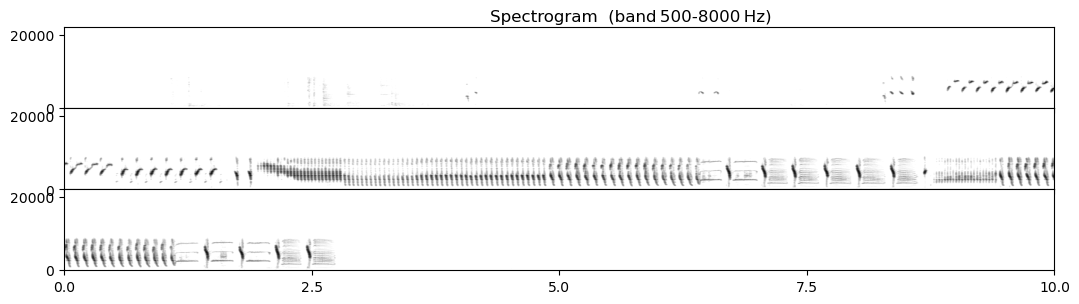

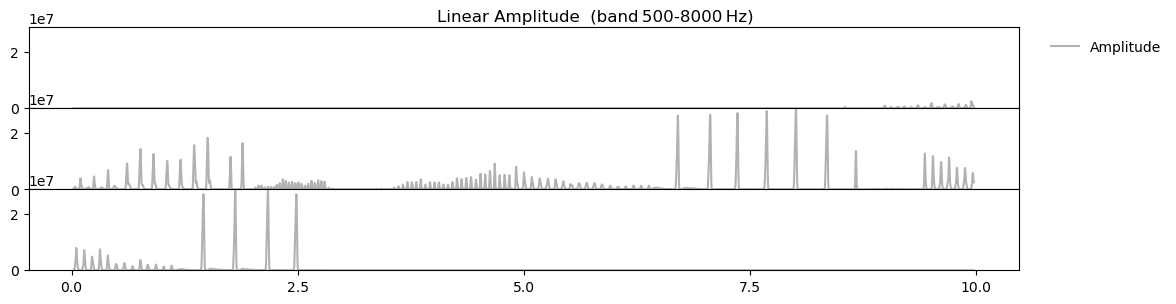

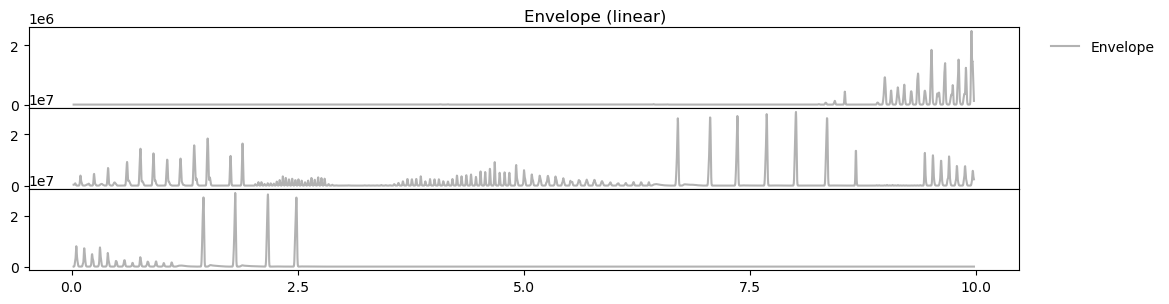

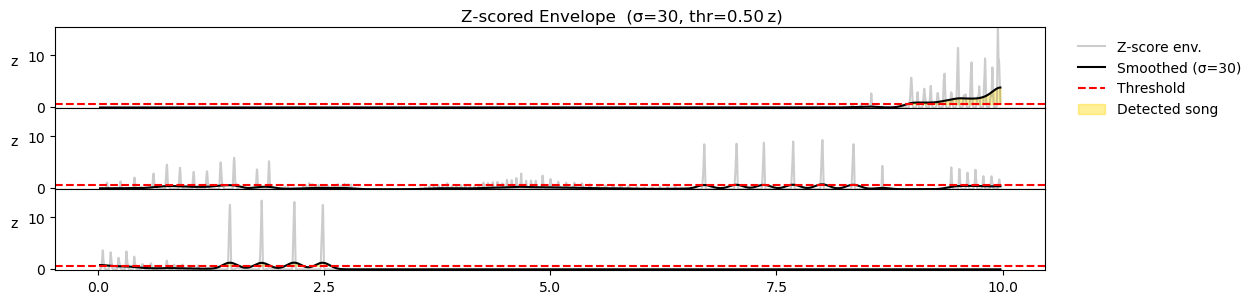

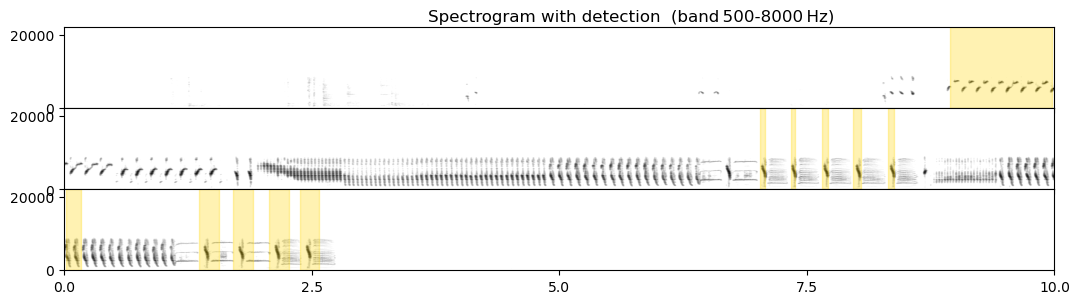


Detected song intervals (s):
      8.95 –     9.97
     17.03 –    17.08
     17.34 –    17.38
     17.65 –    17.71
     17.96 –    18.05
     18.32 –    18.38
     20.02 –    20.17
     21.36 –    21.56
     21.71 –    21.91
     22.07 –    22.27
     22.38 –    22.58


In [16]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_z: float = 100,
    threshold_z: Optional[float] = None,
) -> List[Tuple[float, float]]:

    # --- read & bandpass ---
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut/(sr/2), bandpass_filter_high_cut/(sr/2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # --- segment setup ---
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # --- make figures ---
    figs = [plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                         sharex=True, gridspec_kw={"hspace": 0})
            for _ in range(5)]
    (fig0, axs_spc_raw), (fig1, axs_lin), (fig2, axs_env), \
    (fig3, axs_zsc),   (fig4, axs_spc_det) = figs

    # ensure list of axes
    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_env     = [axs_env]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        # actual segment duration
        start_s = i*seg_len
        real_len = min(seg_len, len(data)-start_s)
        real_dur = real_len / sr

        seg = data[start_s:start_s+seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len-len(seg)))

        # --- spectrogram ---
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048,2048/8),
                                nperseg=2048, noverlap=2048-119)
        Sxx_db = 10*np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min())/(Sxx_db.max()-Sxx_db.min())

        # --- linear envelope ---
        rows = (f>=bandpass_filter_low_cut)&(f<=bandpass_filter_high_cut)
        amp  = np.sum(Sxx[rows,:], axis=0)

        # --- z‑score envelope directly (no log) ---
        mean_amp = amp.mean()
        std_amp  = amp.std() + eps
        amp_z    = (amp - mean_amp)/std_amp

        # --- smooth & threshold ---
        amp_z_s = gaussian_filter1d(amp_z, sigma=sigma_z)
        if threshold_z is None and i==0:
            threshold_z = np.percentile(amp_z_s, 90)
        mask = amp_z_s > threshold_z
        detected.extend(mask_to_intervals(mask, t, i*segment_duration))

        # --- track global limits ---
        gmin_lin = min(gmin_lin, amp.min());  gmax_lin = max(gmax_lin, amp.max())
        gmin_z   = min(gmin_z,   amp_z.min(),   amp_z_s.min(),   threshold_z)
        gmax_z   = max(gmax_z,   amp_z.max(),   amp_z_s.max(),   threshold_z)

        # 1) raw spectrogram
        axR = axs_spc_raw[i]
        axR.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0,segment_duration,f.min(),f.max()],
                   cmap='binary')
        axR.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

        # 2) linear amplitude
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i==0 else None)
        axL.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axL.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02,1.0), frameon=False)

        # 3) raw envelope (same as linear here)
        axE = axs_env[i]
        axE.plot(t, amp, color='gray', alpha=0.6,
                 label='Envelope' if i==0 else None)
        axE.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axE.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02,1.0), frameon=False)

        # 4) z‑scored envelope
        axZ = axs_zsc[i]
        axZ.plot(t, amp_z,   color='gray', alpha=0.4, label='Z‑score env.' if i==0 else None)
        axZ.plot(t, amp_z_s, color='black',              label=f'Smoothed (σ={sigma_z})' if i==0 else None)
        axZ.axhline(threshold_z, color='red', ls='--',
                    label='Threshold' if i==0 else None)
        axZ.fill_between(t, amp_z_s, threshold_z, where=mask,
                         color='gold', alpha=0.4,
                         label='Detected song' if i==0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))
        if i==0:
            axZ.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02,1.0), frameon=False)

        # 5) spectrogram w/ shading
        axS = axs_spc_det[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0,segment_duration,f.min(),f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask, color='gold', alpha=0.3)
        axS.set_xticks([] if i<n_seg-1 else np.linspace(0,segment_duration,5))

    # apply y‑limits
    for ax in axs_lin: ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_zsc: ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle('Envelope (linear)', fontsize=12)
    fig3.suptitle(f'Z‑scored Envelope  (σ={sigma_z}, thr={threshold_z:.2f} z)', fontsize=12)
    fig4.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig, _ in figs:
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s,e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
    if wav_path.exists():
        plot_spectrograms_by_segment(str(wav_path),
                                     sigma_z=30,
                                     threshold_z=0.5)
    else:
        print("WAV not found:", wav_path)


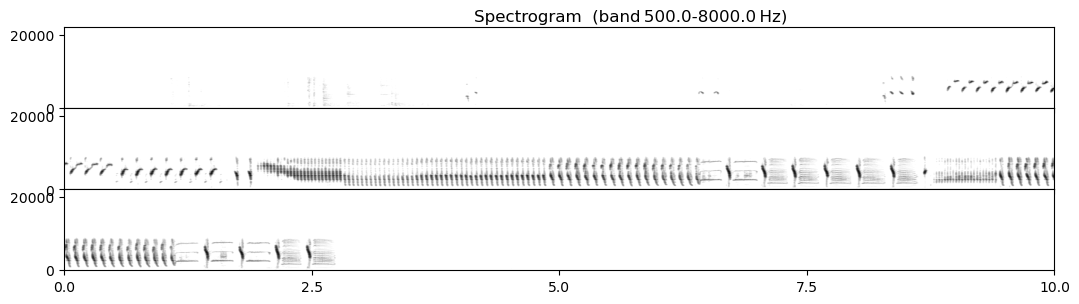

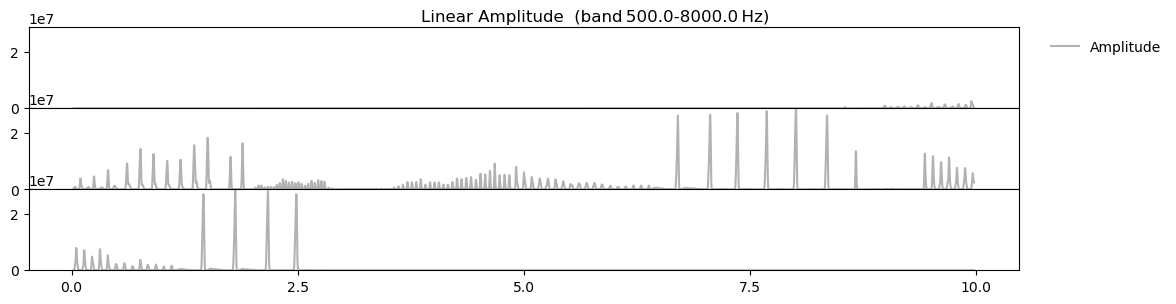

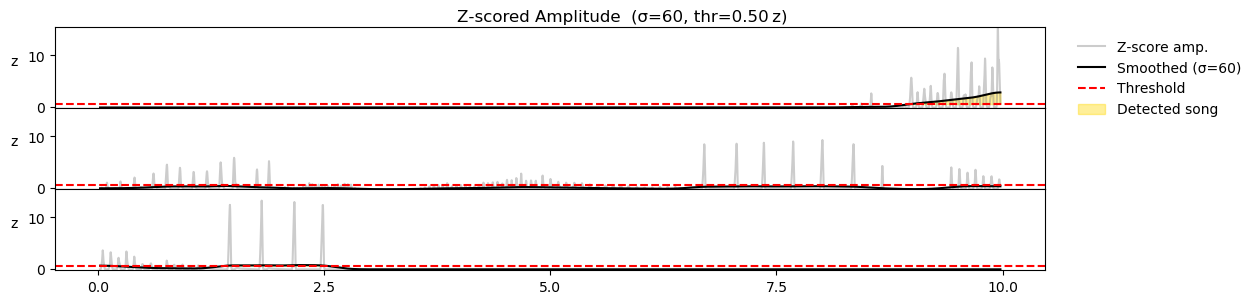

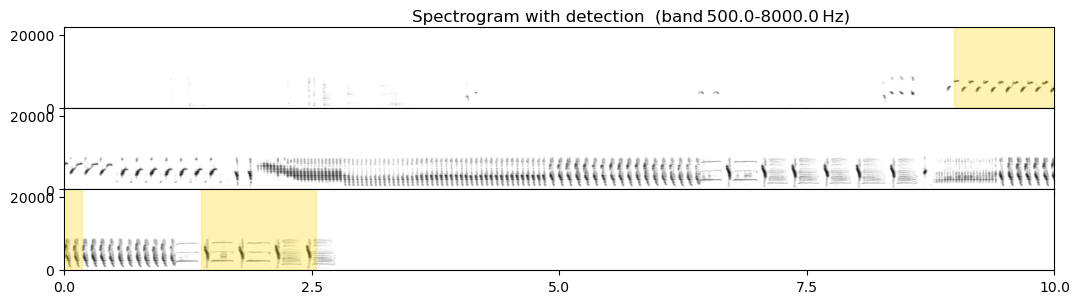


Detected song intervals (s):
      8.99 –     9.97
     20.02 –    20.18
     21.38 –    22.55


In [19]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10.0,
    bandpass_filter_low_cut: float = 500.0,
    bandpass_filter_high_cut: float = 8000.0,
    sigma_z: float = 100.0,
    threshold_z: Optional[float] = None,
) -> List[Tuple[float, float]]:

    # Read & band-pass
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut/(sr/2), bandpass_filter_high_cut/(sr/2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # Segment parameters
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # Prepare four figures: raw spectrogram, linear amp, z-scored amp, spectrogram+det
    figs = [plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                         sharex=True, gridspec_kw={"hspace": 0})
            for _ in range(4)]
    (fig0, axs_spc_raw), (fig1, axs_lin), (fig2, axs_zsc), (fig3, axs_spc_det) = figs

    # Ensure lists
    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        # Compute real duration for last padded segment
        start_s = i * seg_len
        real_len = min(seg_len, len(data) - start_s)
        real_dur = real_len / sr

        seg = data[start_s:start_s+seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048/8),
                                nperseg=2048, noverlap=2048-119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear band-power envelope
        freq_mask = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp = np.sum(Sxx[freq_mask, :], axis=0)

        # Z-score the linear amplitude
        mean_amp = amp.mean()
        std_amp  = amp.std() + eps
        amp_z    = (amp - mean_amp) / std_amp

        # Smooth & threshold
        amp_z_s = gaussian_filter1d(amp_z, sigma=sigma_z)
        if threshold_z is None and i == 0:
            threshold_z = np.percentile(amp_z_s, 90)
        mask = amp_z_s > threshold_z
        detected.extend(mask_to_intervals(mask, t, i * segment_duration))

        # Track global y-limits
        gmin_lin = min(gmin_lin, amp.min());  gmax_lin = max(gmax_lin, amp.max())
        gmin_z   = min(gmin_z,   amp_z.min(),   amp_z_s.min(),   threshold_z)
        gmax_z   = max(gmax_z,   amp_z.max(),   amp_z_s.max(),   threshold_z)

        # 1) Raw spectrogram
        axR = axs_spc_raw[i]
        axR.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axR.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

        # 2) Linear amplitude
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 3) Z‑scored linear amplitude
        axZ = axs_zsc[i]
        axZ.plot(t, amp_z,   color='gray', alpha=0.4,
                 label='Z‑score amp.' if i == 0 else None)
        axZ.plot(t, amp_z_s, color='black',
                 label=f'Smoothed (σ={sigma_z})' if i == 0 else None)
        axZ.axhline(threshold_z, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_z_s, threshold_z, where=mask,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 4) Spectrogram with detection shading
        axS = axs_spc_det[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # Apply shared y‑limits
    for ax in axs_lin:
        ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_zsc:
        ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle(f'Z‑scored Amplitude  (σ={sigma_z}, thr={threshold_z:.2f} z)', fontsize=12)
    fig3.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig, _ in figs:
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            sigma_z=60,
            threshold_z=0.5
        )
    else:
        print("WAV not found:", wav_path)


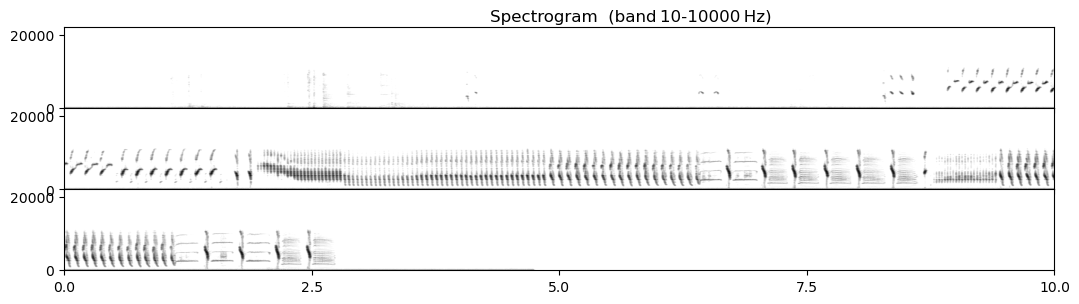

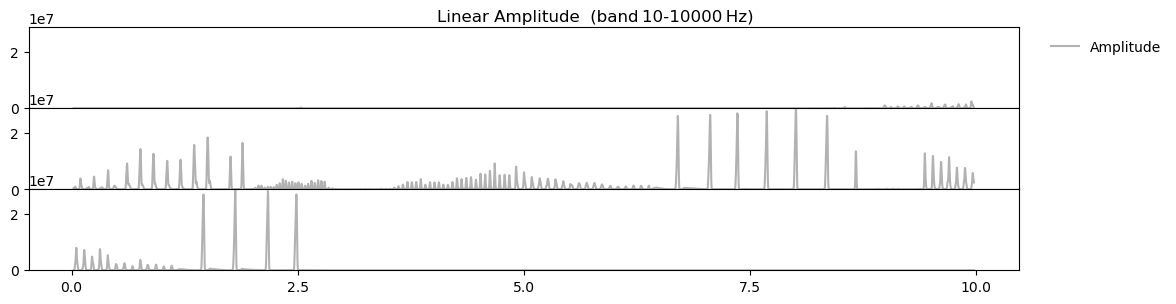

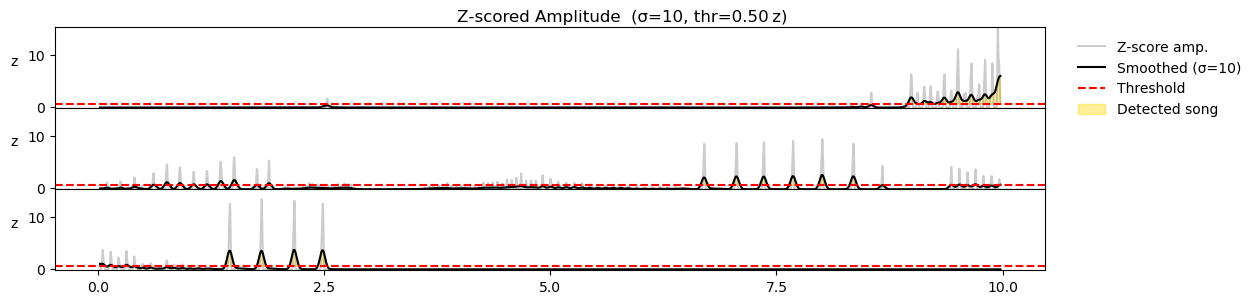

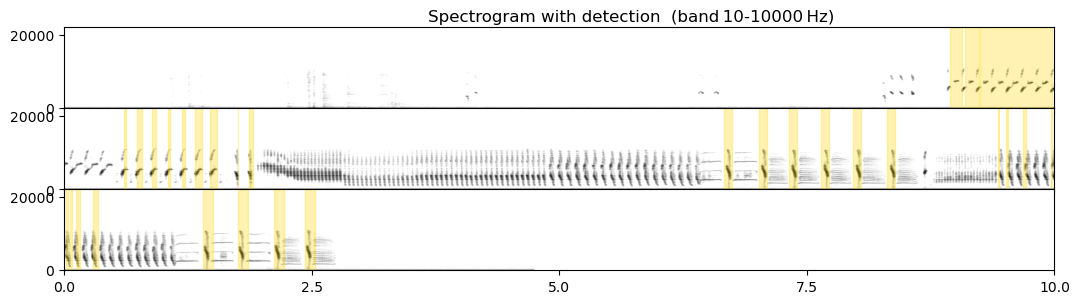


Detected song intervals (s):
      8.95 –     9.07
      9.09 –     9.24
      9.25 –     9.97
     10.61 –    10.63
     10.74 –    10.79
     10.88 –    10.93
     11.05 –    11.08
     11.19 –    11.22
     11.33 –    11.39
     11.47 –    11.55
     11.76 –    11.76
     11.87 –    11.91
     16.66 –    16.74
     17.01 –    17.10
     17.32 –    17.40
     17.64 –    17.72
     17.96 –    18.05
     18.31 –    18.39
     19.43 –    19.44
     19.51 –    19.54
     19.68 –    19.72
     19.97 –    19.97
     20.02 –    20.09
     20.12 –    20.17
     20.29 –    20.34
     21.40 –    21.51
     21.76 –    21.86
     22.12 –    22.22
     22.43 –    22.54


In [28]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, _ = get_screen_resolution()
eps = np.finfo(float).eps

def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: float = 10.0,
    bandpass_filter_low_cut: float = 500.0,
    bandpass_filter_high_cut: float = 8000.0,
    sigma_z: float = 100.0,
    threshold_z: Optional[float] = None,
) -> List[Tuple[float, float]]:

    # Read & band-pass
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [
        bandpass_filter_low_cut / (sr/2),
        bandpass_filter_high_cut / (sr/2)
    ]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # Segment parameters
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # Prepare four figures: raw spectrogram, linear amp, z‑scored amp, spectrogram+det
    figs = [
        plt.subplots(n_seg, 1, figsize=(width_inches, 3), sharex=True, gridspec_kw={"hspace": 0})
        for _ in range(4)
    ]
    (fig0, axs_spc_raw), (fig1, axs_lin), (fig2, axs_zsc), (fig3, axs_spc_det) = figs

    # Ensure lists
    if n_seg == 1:
        axs_spc_raw = [axs_spc_raw]
        axs_lin     = [axs_lin]
        axs_zsc     = [axs_zsc]
        axs_spc_det = [axs_spc_det]

    detected = []
    gmin_lin, gmax_lin = np.inf, -np.inf
    gmin_z,   gmax_z   = np.inf, -np.inf

    for i in range(n_seg):
        # Real duration (to avoid padded tail)
        start_s = i * seg_len
        real_len = min(seg_len, len(data) - start_s)
        real_dur = real_len / sr

        seg = data[start_s:start_s+seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)))

        # Spectrogram
        f, t, Sxx = spectrogram(
            seg, fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048, noverlap=2048-119
        )
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear band‑power envelope
        mask_f = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp    = np.sum(Sxx[mask_f, :], axis=0)

        # Z‑score the linear amplitude
        mean_amp = amp.mean()
        std_amp  = amp.std() + eps
        amp_z    = (amp - mean_amp) / std_amp

        # Smooth & threshold
        amp_z_s = gaussian_filter1d(amp_z, sigma=sigma_z)
        if threshold_z is None and i == 0:
            threshold_z = np.percentile(amp_z_s, 90)
        mask_det = amp_z_s > threshold_z
        detected.extend(mask_to_intervals(mask_det, t, i * segment_duration))

        # Track global y‑limits
        gmin_lin = min(gmin_lin, amp.min());  gmax_lin = max(gmax_lin, amp.max())
        gmin_z   = min(gmin_z,   amp_z.min(), amp_z_s.min(), threshold_z)
        gmax_z   = max(gmax_z,   amp_z.max(), amp_z_s.max(), threshold_z)

        # 1) Raw spectrogram
        axR = axs_spc_raw[i]
        axR.imshow(
            Sxx_n, aspect='auto', origin='lower',
            extent=[0, segment_duration, f.min(), f.max()],
            cmap='binary'
        )
        axR.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

        # 2) Linear amplitude
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.6,
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 3) Z‑scored linear amplitude
        axZ = axs_zsc[i]
        axZ.plot(t, amp_z,   color='gray', alpha=0.4,
                 label='Z‑score amp.' if i == 0 else None)
        axZ.plot(t, amp_z_s, color='black',
                 label=f'Smoothed (σ={sigma_z})' if i == 0 else None)
        axZ.axhline(threshold_z, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, amp_z_s, threshold_z, where=mask_det,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_ylabel('z', rotation=0, labelpad=10)
        axZ.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # 4) Spectrogram with detection shading
        axS = axs_spc_det[i]
        axS.imshow(
            Sxx_n, aspect='auto', origin='lower',
            extent=[0, segment_duration, f.min(), f.max()],
            cmap='binary'
        )
        axS.fill_between(t, f.min(), f.max(), where=mask_det,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # Apply shared y‑limits
    for ax in axs_lin:
        ax.set_ylim(gmin_lin, gmax_lin)
    for ax in axs_zsc:
        ax.set_ylim(gmin_z,   gmax_z)

    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig0.suptitle(f'Spectrogram  (band {bp})', fontsize=12)
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle(f'Z‑scored Amplitude  (σ={sigma_z}, thr={threshold_z:.2f} z)', fontsize=12)
    fig3.suptitle(f'Spectrogram with detection  (band {bp})', fontsize=12)

    for fig, _ in figs:
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

if __name__ == "__main__":
    wav_path = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav")
    if wav_path.exists():
        # User-defined parameters set directly here:
        low_cut     = 10     # Hz
        high_cut    = 10000    # Hz
        sigma_z     = 10      # smoothing window
        threshold_z = 0.5       # z-score threshold

        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            bandpass_filter_low_cut=low_cut,
            bandpass_filter_high_cut=high_cut,
            sigma_z=sigma_z,
            threshold_z=threshold_z
        )
    else:
        print("WAV not found:", wav_path)
